In [1]:
import argparse
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from tqdm import tqdm
from models.GTM_POP import GTM
from utils.data import POPDataset
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from PIL import Image
import torchvision.transforms as T

In [2]:
def cal_error_metrics(gt, forecasts):
    # Absolute errors
    mae = mean_absolute_error(gt, forecasts)
    wape = 100 * np.sum(np.sum(np.abs(gt - forecasts), axis=-1)) / np.sum(gt)

    return round(mae, 3), round(wape, 3)

In [3]:
def get_key_from_dict(dict , vals):
    # list out keys and values separately
    key_list = list(dict.keys())
    val_list = list(dict.values())
     
    # Get key with val 
    keys = []
    keys.append(key_list[val_list.index(vals)])
    return keys

In [4]:
def print_error_metrics(y_test, y_hat, rescaled_y_test, rescaled_y_hat):
    mae, wape = cal_error_metrics(y_test, y_hat)
    rescaled_mae, rescaled_wape = cal_error_metrics(rescaled_y_test, rescaled_y_hat)
    print("MAE: ", mae, "\nWAPE: ", wape, "\nRescaled MAE:",rescaled_mae,"\nRescaled WAPE:", rescaled_wape)

    # plot lines
    plt.plot(rescaled_y_test[0], label = "Actual Sales")
    plt.plot(rescaled_y_hat[0], label = "POP Prediction")
    plt.xlabel('Weeks')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

    # plot lines
    plt.plot(y_test[0], label = "Actual Sales")
    plt.plot(y_hat[0], label = "POP Prediction")
    plt.xlabel('Weeks')
    plt.ylabel('Normalized Sales')
    plt.legend()
    plt.show()

In [5]:
class Args():
    def __init__(self):
        self.data_folder = 'dataset/'
        self.ckpt_path = 'ckpt/POP1_epoch40.ckpt'
        self.gpu_num = 0
        self.seed = 21
        self.img_root = 'dataset/images/'
        self.pop_path = 'signals/pop.pt'
    
        self.model_type = 'GTM'
        self.use_trends = 1
        self.use_img = 1
        self.use_text = 1
        self.trend_len = 52
        self.num_trends = 1
        self.embedding_dim =32 
        self.hidden_dim = 64
        self.output_dim = 12
        self.use_encoder_mask =1
        self.autoregressive = 0
        self.num_attn_heads = 4
        self.num_hidden_layers = 1
        self.decoder_input_type = 3
    
        self.wandb_run = 'Run1'

In [6]:
args = Args()

In [7]:
# Set up CUDA
device = torch.device(f'cuda:{args.gpu_num}' if torch.cuda.is_available() else 'cpu')

# Seeds for reproducibility
pl.seed_everything(args.seed)

# Load sales data    
test_df = pd.read_csv(Path(args.data_folder + 'test.csv'), parse_dates=['release_date'])
item_codes = test_df['external_code'].values

 # Load category and color encodings
cat_dict = torch.load(Path(args.data_folder + 'category_labels.pt'))
col_dict = torch.load(Path(args.data_folder + 'color_labels.pt'))
fab_dict = torch.load(Path(args.data_folder + 'fabric_labels.pt'))

pop_signal = torch.load(args.pop_path)
#print(pop_signal)
test_loader = POPDataset(test_df, args.img_root, pop_signal, cat_dict, col_dict, \
        fab_dict, args.trend_len).get_loader(batch_size=1, train=False)


model_savename = f'{args.wandb_run}_{args.output_dim}'

Global seed set to 21


Starting dataset creation process...


  1%|4                                          | 5/497 [00:00<00:10, 45.07it/s]




External Code: 
 5081 


POP signal: 
 tensor([[0.1110, 0.1146, 0.1154, 0.1100, 0.1176, 0.1147, 0.1118, 0.1147, 0.1115,
         0.1116, 0.1105, 0.1146, 0.1117, 0.1106, 0.1141, 0.1125, 0.1162, 0.1116,
         0.1120, 0.1132, 0.1127, 0.1166, 0.1157, 0.1126, 0.1068, 0.1076, 0.1135,
         0.1149, 0.1186, 0.1184, 0.1197, 0.1194, 0.1213, 0.1228, 0.1214, 0.1203,
         0.1115, 0.1165, 0.1082, 0.1095, 0.1081, 0.1041, 0.1074, 0.1061, 0.1088,
         0.1070, 0.1016, 0.1083, 0.1100, 0.1078, 0.1037, 0.1092]])



External Code: 
 5082 


POP signal: 
 tensor([[0.1107, 0.1117, 0.1095, 0.1087, 0.1083, 0.1100, 0.1096, 0.1159, 0.1133,
         0.1062, 0.1174, 0.1170, 0.1127, 0.1144, 0.1156, 0.1140, 0.1168, 0.1197,
         0.1224, 0.1230, 0.1285, 0.1234, 0.1247, 0.1219, 0.1137, 0.1182, 0.1109,
         0.1192, 0.1242, 0.1259, 0.1231, 0.1163, 0.1147, 0.1146, 0.1121, 0.1069,
         0.1081, 0.1065, 0.1020, 0.1122, 0.1035, 0.1113, 0.1093, 0.1076, 0.1091,
         0.1109, 0.1074, 0.1096, 0.1098

  4%|#6                                        | 19/497 [00:00<00:08, 58.89it/s]




External Code: 
 5092 


POP signal: 
 tensor([[0.1272, 0.1273, 0.1274, 0.1246, 0.1212, 0.1239, 0.1233, 0.1255, 0.1262,
         0.1260, 0.1276, 0.1293, 0.1289, 0.1301, 0.1270, 0.1278, 0.1289, 0.1298,
         0.1286, 0.1292, 0.1282, 0.1284, 0.1257, 0.1270, 0.1276, 0.1277, 0.1230,
         0.1318, 0.1277, 0.1254, 0.1341, 0.1267, 0.1265, 0.1317, 0.1280, 0.1281,
         0.1256, 0.1226, 0.1211, 0.1201, 0.1225, 0.1188, 0.1213, 0.1266, 0.1245,
         0.1173, 0.1182, 0.1195, 0.1193, 0.1208, 0.1210, 0.1214]])



External Code: 
 5093 


POP signal: 
 tensor([[0.1104, 0.1067, 0.1075, 0.1075, 0.1082, 0.1103, 0.1098, 0.1091, 0.1074,
         0.1052, 0.1075, 0.1073, 0.1164, 0.1122, 0.1146, 0.1132, 0.1124, 0.1129,
         0.1180, 0.1278, 0.1268, 0.1191, 0.1149, 0.1096, 0.1128, 0.1164, 0.1158,
         0.1137, 0.1105, 0.1052, 0.1149, 0.1157, 0.1178, 0.1190, 0.1084, 0.1060,
         0.1092, 0.1121, 0.1093, 0.1049, 0.1121, 0.1089, 0.1096, 0.1075, 0.1050,
         0.1017, 0.1019, 0.1045, 0.1018

  6%|##6                                       | 31/497 [00:00<00:08, 56.82it/s]




External Code: 
 5105 


POP signal: 
 tensor([[0.1285, 0.1281, 0.1270, 0.1272, 0.1277, 0.1270, 0.1291, 0.1285, 0.1285,
         0.1286, 0.1270, 0.1320, 0.1303, 0.1305, 0.1295, 0.1276, 0.1218, 0.1330,
         0.1294, 0.1272, 0.1301, 0.1307, 0.1300, 0.1295, 0.1305, 0.1280, 0.1310,
         0.1281, 0.1273, 0.1281, 0.1292, 0.1301, 0.1254, 0.1281, 0.1265, 0.1273,
         0.1245, 0.1195, 0.1196, 0.1197, 0.1131, 0.1216, 0.1187, 0.1226, 0.1251,
         0.1202, 0.1194, 0.1202, 0.1163, 0.1250, 0.1224, 0.1123]])



External Code: 
 5106 


POP signal: 
 tensor([[0.1079, 0.1122, 0.1122, 0.1073, 0.1145, 0.1107, 0.1091, 0.1121, 0.1082,
         0.1076, 0.1078, 0.1131, 0.1095, 0.1076, 0.1113, 0.1090, 0.1138, 0.1091,
         0.1073, 0.1093, 0.1081, 0.1135, 0.1121, 0.1099, 0.1037, 0.1042, 0.1098,
         0.1114, 0.1155, 0.1148, 0.1148, 0.1145, 0.1166, 0.1189, 0.1179, 0.1141,
         0.1049, 0.1123, 0.1041, 0.1063, 0.1046, 0.1002, 0.1040, 0.1036, 0.1051,
         0.1046, 0.0983, 0.1065, 0.1083

  9%|###7                                      | 44/497 [00:00<00:08, 55.42it/s]




External Code: 
 5118 


POP signal: 
 tensor([[0.1143, 0.1084, 0.1128, 0.1145, 0.1118, 0.1120, 0.1147, 0.1083, 0.1101,
         0.1078, 0.1100, 0.1036, 0.1112, 0.1076, 0.1085, 0.1108, 0.1151, 0.1152,
         0.1169, 0.1159, 0.1164, 0.1188, 0.1219, 0.1157, 0.1144, 0.1127, 0.1180,
         0.1207, 0.1244, 0.1142, 0.1214, 0.1227, 0.1227, 0.1239, 0.1090, 0.1113,
         0.1065, 0.1031, 0.1054, 0.1048, 0.1027, 0.1021, 0.0957, 0.0958, 0.0979,
         0.1105, 0.0978, 0.1008, 0.1114, 0.1036, 0.1135, 0.1128]])



External Code: 
 5119 


POP signal: 
 tensor([[0.1108, 0.1129, 0.1142, 0.1169, 0.1166, 0.1086, 0.1139, 0.1180, 0.1183,
         0.1192, 0.1158, 0.1172, 0.1118, 0.1160, 0.1162, 0.1158, 0.1159, 0.1117,
         0.1122, 0.1101, 0.1108, 0.1112, 0.1120, 0.1142, 0.1108, 0.1184, 0.1157,
         0.1161, 0.1131, 0.1083, 0.1083, 0.1120, 0.1129, 0.1093, 0.1027, 0.1033,
         0.0961, 0.1015, 0.1032, 0.1061, 0.1090, 0.1058, 0.1094, 0.1043, 0.1029,
         0.1064, 0.1077, 0.1087, 0.1010

 10%|####2                                     | 50/497 [00:00<00:08, 54.58it/s]




External Code: 
 5129 


POP signal: 
 tensor([[0.1114, 0.1105, 0.1129, 0.1105, 0.1179, 0.1141, 0.1151, 0.1200, 0.1126,
         0.1158, 0.1158, 0.1205, 0.1176, 0.1196, 0.1199, 0.1221, 0.1211, 0.1205,
         0.1176, 0.1112, 0.1132, 0.1110, 0.1112, 0.1104, 0.1119, 0.1075, 0.1103,
         0.1130, 0.1220, 0.1196, 0.1239, 0.1185, 0.1158, 0.1154, 0.1144, 0.1156,
         0.1059, 0.1074, 0.0984, 0.1030, 0.1039, 0.1071, 0.1096, 0.1056, 0.1011,
         0.1113, 0.1078, 0.1095, 0.1090, 0.1017, 0.1082, 0.1064]])



External Code: 
 5130 


POP signal: 
 tensor([[0.1103, 0.1096, 0.1067, 0.1035, 0.1056, 0.1021, 0.1026, 0.1021, 0.0989,
         0.0999, 0.1095, 0.1139, 0.1044, 0.1066, 0.1046, 0.1096, 0.1060, 0.1103,
         0.1142, 0.1153, 0.1142, 0.1132, 0.1100, 0.1086, 0.1109, 0.1071, 0.1078,
         0.1107, 0.1106, 0.1076, 0.1104, 0.1064, 0.1081, 0.1085, 0.1089, 0.1064,
         0.1003, 0.0989, 0.1025, 0.1017, 0.1071, 0.1027, 0.1031, 0.1053, 0.1002,
         0.0982, 0.0997, 0.0984, 0.0966

 11%|####7                                     | 56/497 [00:01<00:08, 53.20it/s]




External Code: 
 5137 


POP signal: 
 tensor([[0.1230, 0.1230, 0.1256, 0.1246, 0.1236, 0.1247, 0.1234, 0.1238, 0.1267,
         0.1253, 0.1248, 0.1253, 0.1218, 0.1225, 0.1224, 0.1210, 0.1211, 0.1249,
         0.1256, 0.1214, 0.1266, 0.1297, 0.1315, 0.1305, 0.1258, 0.1247, 0.1179,
         0.1200, 0.1197, 0.1224, 0.1233, 0.1224, 0.1204, 0.1219, 0.1222, 0.1206,
         0.1225, 0.1271, 0.1237, 0.1208, 0.1205, 0.1209, 0.1223, 0.1218, 0.1242,
         0.1241, 0.1281, 0.1252, 0.1241, 0.1318, 0.1233, 0.1270]])



External Code: 
 5138 


POP signal: 
 tensor([[0.1172, 0.1166, 0.1165, 0.1131, 0.1148, 0.1130, 0.1124, 0.1125, 0.1103,
         0.1106, 0.1193, 0.1220, 0.1147, 0.1179, 0.1144, 0.1167, 0.1144, 0.1178,
         0.1238, 0.1238, 0.1199, 0.1191, 0.1157, 0.1143, 0.1158, 0.1138, 0.1132,
         0.1145, 0.1176, 0.1161, 0.1178, 0.1159, 0.1156, 0.1151, 0.1159, 0.1135,
         0.1106, 0.1107, 0.1136, 0.1133, 0.1189, 0.1148, 0.1167, 0.1166, 0.1109,
         0.1087, 0.1093, 0.1093, 0.1067

 12%|#####2                                    | 62/497 [00:01<00:08, 49.48it/s]




External Code: 
 5140 


POP signal: 
 tensor([[0.1153, 0.1164, 0.1191, 0.1150, 0.1145, 0.1141, 0.1198, 0.1221, 0.1205,
         0.1171, 0.1163, 0.1192, 0.1194, 0.1204, 0.1226, 0.1280, 0.1254, 0.1202,
         0.1135, 0.1180, 0.1179, 0.1200, 0.1231, 0.1216, 0.1173, 0.1100, 0.1163,
         0.1164, 0.1202, 0.1203, 0.1175, 0.1174, 0.1133, 0.1105, 0.1121, 0.1134,
         0.1156, 0.1149, 0.1196, 0.1255, 0.1238, 0.1161, 0.1202, 0.1111, 0.1112,
         0.1109, 0.1128, 0.1132, 0.1051, 0.1092, 0.1111, 0.1085]])



External Code: 
 5141 


POP signal: 
 tensor([[0.1290, 0.1304, 0.1333, 0.1316, 0.1331, 0.1338, 0.1335, 0.1321, 0.1280,
         0.1278, 0.1275, 0.1255, 0.1298, 0.1291, 0.1303, 0.1289, 0.1298, 0.1316,
         0.1298, 0.1297, 0.1289, 0.1297, 0.1316, 0.1297, 0.1302, 0.1334, 0.1356,
         0.1399, 0.1383, 0.1339, 0.1314, 0.1341, 0.1344, 0.1361, 0.1324, 0.1284,
         0.1265, 0.1249, 0.1260, 0.1260, 0.1258, 0.1305, 0.1275, 0.1276, 0.1306,
         0.1244, 0.1288, 0.1275, 0.1269

 14%|#####9                                    | 70/497 [00:01<00:07, 55.68it/s]




External Code: 
 5148 


POP signal: 
 tensor([[0.1233, 0.1265, 0.1252, 0.1190, 0.1200, 0.1201, 0.1179, 0.1179, 0.1165,
         0.1170, 0.1242, 0.1270, 0.1226, 0.1292, 0.1251, 0.1229, 0.1227, 0.1247,
         0.1249, 0.1223, 0.1179, 0.1227, 0.1213, 0.1216, 0.1177, 0.1181, 0.1233,
         0.1262, 0.1298, 0.1307, 0.1302, 0.1165, 0.1133, 0.1115, 0.1149, 0.1142,
         0.1084, 0.1210, 0.1178, 0.1158, 0.1145, 0.1163, 0.1138, 0.1160, 0.1066,
         0.1085, 0.1104, 0.1110, 0.1138, 0.1172, 0.1197, 0.1114]])



External Code: 
 5149 


POP signal: 
 tensor([[0.1273, 0.1190, 0.1275, 0.1206, 0.1103, 0.1111, 0.1194, 0.1174, 0.1179,
         0.1247, 0.1215, 0.1302, 0.1277, 0.1382, 0.1330, 0.1266, 0.1212, 0.1239,
         0.1211, 0.1230, 0.1233, 0.1260, 0.1249, 0.1117, 0.1163, 0.1083, 0.1148,
         0.1121, 0.1214, 0.1182, 0.1201, 0.1132, 0.1206, 0.1193, 0.1196, 0.1213,
         0.1188, 0.1158, 0.1104, 0.1105, 0.1116, 0.1137, 0.1138, 0.1099, 0.1026,
         0.1069, 0.1083, 0.1126, 0.1138

 15%|######4                                   | 76/497 [00:01<00:07, 56.26it/s]




External Code: 
 5152 


POP signal: 
 tensor([[0.1229, 0.1213, 0.1224, 0.1206, 0.1204, 0.1235, 0.1249, 0.1236, 0.1247,
         0.1254, 0.1271, 0.1247, 0.1230, 0.1257, 0.1189, 0.1259, 0.1226, 0.1212,
         0.1212, 0.1264, 0.1257, 0.1244, 0.1282, 0.1214, 0.1230, 0.1240, 0.1198,
         0.1215, 0.1190, 0.1172, 0.1178, 0.1201, 0.1209, 0.1189, 0.1176, 0.1155,
         0.1128, 0.1146, 0.1137, 0.1152, 0.1131, 0.1148, 0.1182, 0.1134, 0.1077,
         0.1102, 0.1097, 0.1070, 0.1110, 0.1162, 0.1148, 0.1128]])



External Code: 
 5153 


POP signal: 
 tensor([[0.1069, 0.1033, 0.1055, 0.1025, 0.1037, 0.1052, 0.1082, 0.1081, 0.1097,
         0.1100, 0.1106, 0.1090, 0.1077, 0.1108, 0.1060, 0.1043, 0.1053, 0.1057,
         0.1104, 0.1077, 0.1023, 0.1111, 0.1046, 0.1011, 0.1066, 0.1086, 0.1101,
         0.1041, 0.1099, 0.1151, 0.1098, 0.1099, 0.1106, 0.1099, 0.1094, 0.1068,
         0.0998, 0.1001, 0.0991, 0.1038, 0.1063, 0.1019, 0.0974, 0.1006, 0.0988,
         0.1002, 0.1005, 0.0983, 0.1014

 18%|#######4                                  | 88/497 [00:01<00:07, 52.35it/s]




External Code: 
 5163 


POP signal: 
 tensor([[0.1070, 0.1031, 0.1017, 0.0987, 0.1068, 0.1063, 0.1090, 0.1089, 0.1143,
         0.1112, 0.1143, 0.1161, 0.1127, 0.1129, 0.1184, 0.1207, 0.1186, 0.1183,
         0.1057, 0.1068, 0.1064, 0.1075, 0.1083, 0.1122, 0.1120, 0.1122, 0.1157,
         0.1171, 0.1179, 0.1229, 0.1252, 0.1108, 0.1005, 0.1108, 0.0991, 0.1063,
         0.1077, 0.1037, 0.1089, 0.1099, 0.1115, 0.1022, 0.1037, 0.1107, 0.1074,
         0.1097, 0.1004, 0.1024, 0.1034, 0.0911, 0.1005, 0.0909]])



External Code: 
 5164 


POP signal: 
 tensor([[0.1212, 0.1181, 0.1173, 0.1200, 0.1149, 0.1152, 0.1111, 0.1079, 0.1124,
         0.1163, 0.1200, 0.1243, 0.1122, 0.1131, 0.1170, 0.1116, 0.1129, 0.1157,
         0.1164, 0.1155, 0.1186, 0.1217, 0.1216, 0.1242, 0.1246, 0.1188, 0.1199,
         0.1207, 0.1224, 0.1219, 0.1239, 0.1189, 0.1219, 0.1153, 0.1176, 0.1136,
         0.1137, 0.1169, 0.1158, 0.1150, 0.1117, 0.1123, 0.1144, 0.1134, 0.1173,
         0.1193, 0.1163, 0.1150, 0.1169

 19%|#######9                                  | 94/497 [00:01<00:07, 53.74it/s]




External Code: 
 5175 


POP signal: 
 tensor([[0.1076, 0.1058, 0.1119, 0.1124, 0.1130, 0.1108, 0.1107, 0.1086, 0.1085,
         0.1105, 0.1085, 0.1067, 0.1068, 0.1070, 0.1059, 0.1076, 0.1066, 0.1086,
         0.1072, 0.1084, 0.1083, 0.1069, 0.1085, 0.1081, 0.1102, 0.1098, 0.1105,
         0.1115, 0.1105, 0.1057, 0.1059, 0.1075, 0.1097, 0.1086, 0.1087, 0.1039,
         0.1005, 0.1027, 0.1019, 0.1021, 0.1017, 0.1027, 0.1041, 0.1087, 0.1071,
         0.1067, 0.1022, 0.0988, 0.0988, 0.0982, 0.1012, 0.1027]])



External Code: 
 5176 


POP signal: 
 tensor([[0.1223, 0.1203, 0.1254, 0.1278, 0.1278, 0.1255, 0.1258, 0.1225, 0.1202,
         0.1215, 0.1204, 0.1202, 0.1191, 0.1205, 0.1183, 0.1216, 0.1197, 0.1230,
         0.1221, 0.1212, 0.1218, 0.1205, 0.1222, 0.1235, 0.1266, 0.1244, 0.1225,
         0.1258, 0.1234, 0.1199, 0.1191, 0.1208, 0.1223, 0.1204, 0.1198, 0.1158,
         0.1108, 0.1138, 0.1139, 0.1152, 0.1158, 0.1163, 0.1152, 0.1206, 0.1194,
         0.1187, 0.1146, 0.1106, 0.1117

 20%|########3                                | 101/497 [00:01<00:07, 55.28it/s]




External Code: 
 5182 


POP signal: 
 tensor([[0.1309, 0.1321, 0.1319, 0.1317, 0.1286, 0.1265, 0.1269, 0.1228, 0.1207,
         0.1284, 0.1204, 0.1199, 0.1240, 0.1231, 0.1212, 0.1200, 0.1250, 0.1272,
         0.1245, 0.1254, 0.1262, 0.1202, 0.1224, 0.1212, 0.1248, 0.1235, 0.1280,
         0.1302, 0.1262, 0.1264, 0.1216, 0.1262, 0.1238, 0.1215, 0.1216, 0.1215,
         0.1178, 0.1245, 0.1265, 0.1232, 0.1176, 0.1178, 0.1153, 0.1169, 0.1164,
         0.1164, 0.1167, 0.1177, 0.1170, 0.1229, 0.1216, 0.1229]])



External Code: 
 5183 


POP signal: 
 tensor([[0.1102, 0.1121, 0.1104, 0.1107, 0.1124, 0.1153, 0.1120, 0.1124, 0.1141,
         0.1164, 0.1166, 0.1138, 0.1195, 0.1136, 0.1111, 0.1123, 0.1128, 0.1178,
         0.1151, 0.1085, 0.1174, 0.1113, 0.1079, 0.1136, 0.1145, 0.1173, 0.1123,
         0.1152, 0.1217, 0.1169, 0.1181, 0.1187, 0.1167, 0.1166, 0.1130, 0.1068,
         0.1077, 0.1071, 0.1119, 0.1147, 0.1086, 0.1038, 0.1049, 0.1051, 0.1066,
         0.1076, 0.1063, 0.1087, 0.1136

 22%|########8                                | 107/497 [00:01<00:07, 55.62it/s]




External Code: 
 5187 


POP signal: 
 tensor([[0.1152, 0.1085, 0.1033, 0.1070, 0.1044, 0.1041, 0.1078, 0.1061, 0.1087,
         0.1057, 0.1097, 0.1044, 0.1056, 0.1059, 0.1110, 0.1141, 0.1158, 0.1182,
         0.1155, 0.1159, 0.1179, 0.1148, 0.1134, 0.1163, 0.1163, 0.1150, 0.1116,
         0.1139, 0.1163, 0.1143, 0.1153, 0.1135, 0.1107, 0.1103, 0.1075, 0.1096,
         0.1024, 0.1064, 0.1055, 0.1040, 0.1059, 0.1050, 0.1076, 0.1086, 0.1043,
         0.1037, 0.1023, 0.1042, 0.1031, 0.1023, 0.1029, 0.1006]])



External Code: 
 5188 


POP signal: 
 tensor([[0.1163, 0.1212, 0.1224, 0.1205, 0.1154, 0.1156, 0.1144, 0.1128, 0.1132,
         0.1102, 0.1164, 0.1150, 0.1182, 0.1172, 0.1187, 0.1157, 0.1147, 0.1186,
         0.1187, 0.1213, 0.1232, 0.1220, 0.1191, 0.1193, 0.1165, 0.1180, 0.1187,
         0.1206, 0.1225, 0.1221, 0.1205, 0.1212, 0.1165, 0.1144, 0.1129, 0.1116,
         0.1068, 0.1078, 0.1116, 0.1116, 0.1158, 0.1094, 0.1076, 0.1111, 0.1105,
         0.1099, 0.1078, 0.1089, 0.1064

 23%|#########3                               | 113/497 [00:02<00:06, 54.90it/s]




External Code: 
 5193 


POP signal: 
 tensor([[0.1196, 0.1199, 0.1182, 0.1162, 0.1078, 0.1116, 0.1083, 0.1115, 0.1147,
         0.1103, 0.1097, 0.1114, 0.1147, 0.1109, 0.1130, 0.1166, 0.1119, 0.1160,
         0.1112, 0.1200, 0.1180, 0.1113, 0.1136, 0.1191, 0.1191, 0.1187, 0.1208,
         0.1142, 0.1169, 0.1151, 0.1154, 0.1109, 0.1095, 0.1064, 0.1049, 0.0991,
         0.1092, 0.1089, 0.1079, 0.1113, 0.1087, 0.1077, 0.1068, 0.1049, 0.1061,
         0.1060, 0.1046, 0.1090, 0.1085, 0.1054, 0.1065, 0.1060]])



External Code: 
 5194 


POP signal: 
 tensor([[0.1121, 0.1112, 0.1143, 0.1113, 0.1136, 0.1119, 0.1101, 0.1143, 0.1171,
         0.1131, 0.1138, 0.1147, 0.1133, 0.1138, 0.1166, 0.1164, 0.1181, 0.1129,
         0.1129, 0.1148, 0.1064, 0.1091, 0.1105, 0.1139, 0.1167, 0.1115, 0.1148,
         0.1081, 0.1098, 0.1124, 0.1138, 0.1146, 0.1120, 0.1104, 0.1041, 0.1097,
         0.1052, 0.1051, 0.1066, 0.1115, 0.1106, 0.1117, 0.1097, 0.1074, 0.1096,
         0.1093, 0.1105, 0.1106, 0.1050

 24%|#########8                               | 119/497 [00:02<00:07, 52.23it/s]




External Code: 
 5198 


POP signal: 
 tensor([[0.1135, 0.1121, 0.1104, 0.1108, 0.1110, 0.1099, 0.1096, 0.1102, 0.1108,
         0.1071, 0.1056, 0.1030, 0.1023, 0.1105, 0.1095, 0.1107, 0.1154, 0.1132,
         0.1163, 0.1185, 0.1145, 0.1148, 0.1140, 0.1169, 0.1130, 0.1185, 0.1182,
         0.1199, 0.1173, 0.1137, 0.1142, 0.1057, 0.1068, 0.1037, 0.1087, 0.1109,
         0.1105, 0.1106, 0.1088, 0.1086, 0.1065, 0.1132, 0.1083, 0.1045, 0.1014,
         0.0996, 0.0992, 0.1017, 0.1009, 0.0979, 0.0997, 0.0960]])



External Code: 
 5199 


POP signal: 
 tensor([[0.1281, 0.1212, 0.1254, 0.1271, 0.1229, 0.1230, 0.1242, 0.1218, 0.1217,
         0.1192, 0.1228, 0.1275, 0.1272, 0.1310, 0.1308, 0.1241, 0.1215, 0.1206,
         0.1225, 0.1222, 0.1251, 0.1231, 0.1256, 0.1229, 0.1227, 0.1246, 0.1233,
         0.1233, 0.1249, 0.1235, 0.1279, 0.1217, 0.1204, 0.1256, 0.1182, 0.1207,
         0.1166, 0.1187, 0.1191, 0.1211, 0.1149, 0.1203, 0.1198, 0.1226, 0.1238,
         0.1221, 0.1226, 0.1214, 0.1181

 25%|##########3                              | 125/497 [00:02<00:07, 52.67it/s]




External Code: 
 5204 


POP signal: 
 tensor([[0.1161, 0.1140, 0.1119, 0.1117, 0.1127, 0.1101, 0.1116, 0.1133, 0.1141,
         0.1074, 0.1059, 0.1047, 0.1037, 0.1122, 0.1123, 0.1145, 0.1188, 0.1155,
         0.1180, 0.1196, 0.1157, 0.1151, 0.1149, 0.1176, 0.1127, 0.1174, 0.1206,
         0.1224, 0.1192, 0.1153, 0.1161, 0.1071, 0.1064, 0.1030, 0.1071, 0.1110,
         0.1119, 0.1130, 0.1103, 0.1098, 0.1068, 0.1129, 0.1068, 0.1033, 0.1009,
         0.0997, 0.0993, 0.1008, 0.0987, 0.0953, 0.0976, 0.0951]])



External Code: 
 5205 


POP signal: 
 tensor([[0.1189, 0.1189, 0.1154, 0.1160, 0.1167, 0.1183, 0.1203, 0.1202, 0.1236,
         0.1255, 0.1273, 0.1291, 0.1264, 0.1269, 0.1143, 0.1176, 0.1218, 0.1228,
         0.1217, 0.1211, 0.1160, 0.1210, 0.1185, 0.1220, 0.1191, 0.1174, 0.1245,
         0.1226, 0.1190, 0.1223, 0.1223, 0.1278, 0.1256, 0.1256, 0.1186, 0.1102,
         0.1130, 0.1147, 0.1175, 0.1156, 0.1172, 0.1140, 0.1083, 0.1139, 0.1175,
         0.1179, 0.1147, 0.1092, 0.1110

 26%|##########8                              | 131/497 [00:02<00:07, 52.11it/s]




External Code: 
 5209 


POP signal: 
 tensor([[0.1148, 0.1185, 0.1164, 0.1187, 0.1132, 0.1130, 0.1136, 0.1135, 0.1148,
         0.1145, 0.1162, 0.1225, 0.1158, 0.1158, 0.1193, 0.1183, 0.1188, 0.1200,
         0.1162, 0.1167, 0.1126, 0.1162, 0.1176, 0.1145, 0.1166, 0.1148, 0.1194,
         0.1205, 0.1246, 0.1221, 0.1134, 0.1125, 0.1133, 0.1093, 0.1105, 0.1118,
         0.1076, 0.1015, 0.1013, 0.1031, 0.0995, 0.1066, 0.1024, 0.1066, 0.1099,
         0.1086, 0.1163, 0.1126, 0.1042, 0.1034, 0.1011, 0.1045]])



External Code: 
 5210 


POP signal: 
 tensor([[0.1179, 0.1175, 0.1162, 0.1136, 0.1050, 0.1091, 0.1050, 0.1094, 0.1109,
         0.1064, 0.1072, 0.1079, 0.1132, 0.1085, 0.1110, 0.1129, 0.1089, 0.1125,
         0.1083, 0.1168, 0.1154, 0.1094, 0.1121, 0.1166, 0.1173, 0.1161, 0.1161,
         0.1106, 0.1136, 0.1121, 0.1113, 0.1076, 0.1077, 0.1055, 0.1017, 0.0967,
         0.1064, 0.1063, 0.1059, 0.1088, 0.1076, 0.1045, 0.1043, 0.1028, 0.1037,
         0.1026, 0.1017, 0.1041, 0.1042

 28%|###########3                             | 137/497 [00:02<00:06, 53.12it/s]




External Code: 
 5215 


POP signal: 
 tensor([[0.1180, 0.1110, 0.1152, 0.1194, 0.1228, 0.1164, 0.1189, 0.1161, 0.1158,
         0.1142, 0.1154, 0.1173, 0.1230, 0.1190, 0.1174, 0.1198, 0.1178, 0.1188,
         0.1216, 0.1205, 0.1185, 0.1190, 0.1194, 0.1230, 0.1226, 0.1202, 0.1160,
         0.1233, 0.1201, 0.1143, 0.1138, 0.1168, 0.1215, 0.1185, 0.1155, 0.1118,
         0.1094, 0.1128, 0.1068, 0.1033, 0.1052, 0.1073, 0.1118, 0.1125, 0.1070,
         0.1048, 0.1031, 0.1058, 0.1066, 0.1051, 0.1109, 0.1099]])



External Code: 
 5216 


POP signal: 
 tensor([[0.1269, 0.1255, 0.1265, 0.1259, 0.1235, 0.1235, 0.1274, 0.1277, 0.1315,
         0.1290, 0.1268, 0.1287, 0.1270, 0.1190, 0.1305, 0.1261, 0.1241, 0.1270,
         0.1283, 0.1281, 0.1303, 0.1314, 0.1257, 0.1295, 0.1276, 0.1267, 0.1263,
         0.1254, 0.1291, 0.1262, 0.1292, 0.1296, 0.1270, 0.1231, 0.1168, 0.1185,
         0.1149, 0.1080, 0.1174, 0.1147, 0.1164, 0.1207, 0.1136, 0.1143, 0.1175,
         0.1133, 0.1207, 0.1149, 0.1101

 29%|###########7                             | 143/497 [00:02<00:06, 53.49it/s]




External Code: 
 5221 


POP signal: 
 tensor([[0.1263, 0.1240, 0.1208, 0.1178, 0.1208, 0.1220, 0.1164, 0.1222, 0.1224,
         0.1187, 0.1219, 0.1238, 0.1194, 0.1196, 0.1172, 0.1222, 0.1239, 0.1207,
         0.1214, 0.1207, 0.1211, 0.1233, 0.1223, 0.1222, 0.1244, 0.1301, 0.1274,
         0.1289, 0.1328, 0.1330, 0.1337, 0.1283, 0.1229, 0.1180, 0.1210, 0.1207,
         0.1243, 0.1290, 0.1281, 0.1222, 0.1184, 0.1158, 0.1202, 0.1206, 0.1206,
         0.1253, 0.1265, 0.1212, 0.1271, 0.1228, 0.1158, 0.1132]])



External Code: 
 5222 


POP signal: 
 tensor([[0.1148, 0.1094, 0.1126, 0.1096, 0.1076, 0.1137, 0.1103, 0.1145, 0.1112,
         0.1155, 0.1090, 0.1113, 0.1104, 0.1182, 0.1214, 0.1229, 0.1263, 0.1211,
         0.1224, 0.1236, 0.1200, 0.1177, 0.1225, 0.1229, 0.1224, 0.1200, 0.1202,
         0.1210, 0.1206, 0.1192, 0.1178, 0.1175, 0.1162, 0.1139, 0.1148, 0.1069,
         0.1129, 0.1114, 0.1107, 0.1125, 0.1094, 0.1127, 0.1146, 0.1108, 0.1116,
         0.1107, 0.1137, 0.1114, 0.1107

 30%|############2                            | 149/497 [00:02<00:06, 52.50it/s]




External Code: 
 5226 


POP signal: 
 tensor([[0.1163, 0.1139, 0.1154, 0.1121, 0.1124, 0.1129, 0.1094, 0.1104, 0.1187,
         0.1225, 0.1134, 0.1169, 0.1138, 0.1180, 0.1146, 0.1190, 0.1246, 0.1248,
         0.1221, 0.1207, 0.1183, 0.1161, 0.1197, 0.1164, 0.1156, 0.1183, 0.1193,
         0.1156, 0.1190, 0.1161, 0.1159, 0.1163, 0.1178, 0.1150, 0.1097, 0.1087,
         0.1142, 0.1131, 0.1201, 0.1146, 0.1153, 0.1164, 0.1100, 0.1082, 0.1089,
         0.1075, 0.1066, 0.1080, 0.1010, 0.0998, 0.1012, 0.1027]])



External Code: 
 5227 


POP signal: 
 tensor([[0.1318, 0.1276, 0.1270, 0.1280, 0.1264, 0.1295, 0.1269, 0.1256, 0.1315,
         0.1322, 0.1359, 0.1356, 0.1364, 0.1343, 0.1321, 0.1321, 0.1288, 0.1296,
         0.1265, 0.1282, 0.1296, 0.1290, 0.1235, 0.1251, 0.1302, 0.1344, 0.1346,
         0.1344, 0.1328, 0.1275, 0.1243, 0.1271, 0.1275, 0.1264, 0.1226, 0.1300,
         0.1271, 0.1273, 0.1256, 0.1277, 0.1280, 0.1293, 0.1211, 0.1219, 0.1241,
         0.1251, 0.1253, 0.1260, 0.1271

 31%|############7                            | 155/497 [00:02<00:06, 50.27it/s]




External Code: 
 5236 


POP signal: 
 tensor([[0.1274, 0.1275, 0.1265, 0.1238, 0.1245, 0.1235, 0.1293, 0.1230, 0.1306,
         0.1244, 0.1309, 0.1317, 0.1273, 0.1288, 0.1266, 0.1274, 0.1249, 0.1279,
         0.1272, 0.1326, 0.1263, 0.1257, 0.1223, 0.1204, 0.1217, 0.1249, 0.1260,
         0.1254, 0.1269, 0.1251, 0.1324, 0.1256, 0.1256, 0.1265, 0.1219, 0.1218,
         0.1173, 0.1199, 0.1176, 0.1201, 0.1186, 0.1171, 0.1213, 0.1243, 0.1295,
         0.1277, 0.1236, 0.1240, 0.1200, 0.1181, 0.1202, 0.1237]])



External Code: 
 5237 


POP signal: 
 tensor([[0.1184, 0.1155, 0.1174, 0.1166, 0.1176, 0.1258, 0.1294, 0.1290, 0.1197,
         0.1143, 0.1191, 0.1172, 0.1195, 0.1185, 0.1197, 0.1213, 0.1208, 0.1258,
         0.1166, 0.1240, 0.1219, 0.1218, 0.1263, 0.1193, 0.1184, 0.1154, 0.1099,
         0.1125, 0.1146, 0.1215, 0.1277, 0.1209, 0.1145, 0.1066, 0.1029, 0.1022,
         0.1101, 0.1127, 0.1124, 0.1137, 0.1105, 0.1078, 0.1100, 0.1051, 0.1173,
         0.1069, 0.1090, 0.1081, 0.1129

 32%|#############2                           | 161/497 [00:03<00:06, 48.71it/s]




External Code: 
 5242 


POP signal: 
 tensor([[0.1284, 0.1292, 0.1259, 0.1255, 0.1275, 0.1286, 0.1368, 0.1285, 0.1276,
         0.1261, 0.1267, 0.1319, 0.1261, 0.1251, 0.1324, 0.1287, 0.1320, 0.1347,
         0.1267, 0.1316, 0.1300, 0.1344, 0.1337, 0.1264, 0.1282, 0.1297, 0.1337,
         0.1344, 0.1323, 0.1296, 0.1281, 0.1305, 0.1240, 0.1225, 0.1226, 0.1195,
         0.1244, 0.1203, 0.1218, 0.1217, 0.1246, 0.1238, 0.1263, 0.1276, 0.1265,
         0.1222, 0.1283, 0.1226, 0.1272, 0.1288, 0.1269, 0.1308]])



External Code: 
 5243 


POP signal: 
 tensor([[0.1239, 0.1211, 0.1202, 0.1198, 0.1225, 0.1212, 0.1213, 0.1224, 0.1196,
         0.1224, 0.1203, 0.1219, 0.1169, 0.1163, 0.1196, 0.1175, 0.1176, 0.1229,
         0.1208, 0.1232, 0.1136, 0.1121, 0.1143, 0.1113, 0.1170, 0.1197, 0.1249,
         0.1275, 0.1209, 0.1222, 0.1177, 0.1159, 0.1196, 0.1120, 0.1163, 0.1101,
         0.1073, 0.1063, 0.1052, 0.1026, 0.1081, 0.1078, 0.1181, 0.1188, 0.1200,
         0.1187, 0.1173, 0.1049, 0.1049

 33%|#############6                           | 166/497 [00:03<00:06, 48.61it/s]




External Code: 
 5245 


POP signal: 
 tensor([[0.1051, 0.1079, 0.1054, 0.1046, 0.1103, 0.1075, 0.1108, 0.1078, 0.1122,
         0.1068, 0.1076, 0.1073, 0.1135, 0.1169, 0.1181, 0.1221, 0.1183, 0.1198,
         0.1206, 0.1167, 0.1148, 0.1189, 0.1190, 0.1190, 0.1169, 0.1181, 0.1201,
         0.1177, 0.1174, 0.1166, 0.1143, 0.1132, 0.1100, 0.1122, 0.1034, 0.1084,
         0.1070, 0.1067, 0.1091, 0.1063, 0.1097, 0.1112, 0.1072, 0.1079, 0.1057,
         0.1090, 0.1068, 0.1049, 0.1054, 0.1029, 0.1062, 0.1062]])



External Code: 
 5246 


POP signal: 
 tensor([[0.1155, 0.1227, 0.1252, 0.1193, 0.1199, 0.1214, 0.1202, 0.1189, 0.1160,
         0.1206, 0.1248, 0.1244, 0.1307, 0.1298, 0.1217, 0.1172, 0.1163, 0.1180,
         0.1182, 0.1220, 0.1201, 0.1231, 0.1202, 0.1194, 0.1236, 0.1205, 0.1204,
         0.1228, 0.1210, 0.1272, 0.1178, 0.1156, 0.1243, 0.1144, 0.1176, 0.1126,
         0.1147, 0.1159, 0.1185, 0.1099, 0.1165, 0.1170, 0.1193, 0.1214, 0.1195,
         0.1192, 0.1186, 0.1150, 0.1194

 35%|##############2                          | 173/497 [00:03<00:06, 52.72it/s]




External Code: 
 5253 


POP signal: 
 tensor([[0.1234, 0.1221, 0.1197, 0.1176, 0.1197, 0.1200, 0.1197, 0.1204, 0.1177,
         0.1149, 0.1174, 0.1241, 0.1199, 0.1224, 0.1246, 0.1209, 0.1246, 0.1212,
         0.1263, 0.1242, 0.1206, 0.1221, 0.1256, 0.1253, 0.1250, 0.1277, 0.1219,
         0.1236, 0.1220, 0.1215, 0.1204, 0.1205, 0.1169, 0.1168, 0.1115, 0.1189,
         0.1181, 0.1180, 0.1213, 0.1196, 0.1187, 0.1189, 0.1180, 0.1171, 0.1162,
         0.1161, 0.1192, 0.1171, 0.1163, 0.1180, 0.1180, 0.1162]])



External Code: 
 5254 


POP signal: 
 tensor([[0.1161, 0.1152, 0.1226, 0.1194, 0.1197, 0.1199, 0.1203, 0.1207, 0.1213,
         0.1226, 0.1221, 0.1289, 0.1254, 0.1229, 0.1231, 0.1194, 0.1185, 0.1208,
         0.1218, 0.1218, 0.1190, 0.1204, 0.1180, 0.1198, 0.1192, 0.1198, 0.1220,
         0.1187, 0.1247, 0.1237, 0.1168, 0.1165, 0.1149, 0.1120, 0.1176, 0.1149,
         0.1177, 0.1157, 0.1120, 0.1144, 0.1164, 0.1166, 0.1160, 0.1183, 0.1124,
         0.1183, 0.1176, 0.1193, 0.1158

 36%|##############7                          | 179/497 [00:03<00:06, 52.28it/s]




External Code: 
 5257 


POP signal: 
 tensor([[0.1081, 0.1131, 0.1158, 0.1188, 0.1195, 0.1206, 0.1188, 0.1162, 0.1161,
         0.1196, 0.1178, 0.1142, 0.1162, 0.1169, 0.1152, 0.1188, 0.1146, 0.1113,
         0.1142, 0.1091, 0.1138, 0.1129, 0.1208, 0.1161, 0.1194, 0.1183, 0.1152,
         0.1178, 0.1221, 0.1203, 0.1204, 0.1214, 0.1146, 0.1114, 0.1093, 0.1103,
         0.1121, 0.1133, 0.1142, 0.1189, 0.1199, 0.1180, 0.1173, 0.1123, 0.1110,
         0.1103, 0.1186, 0.1126, 0.1138, 0.1140, 0.1171, 0.1158]])



External Code: 
 5258 


POP signal: 
 tensor([[0.1143, 0.1091, 0.1113, 0.1140, 0.1123, 0.1132, 0.1162, 0.1170, 0.1065,
         0.1060, 0.1032, 0.1013, 0.1168, 0.1143, 0.1159, 0.1212, 0.1184, 0.1191,
         0.1201, 0.1157, 0.1150, 0.1150, 0.1198, 0.1149, 0.1204, 0.1228, 0.1253,
         0.1230, 0.1175, 0.1196, 0.1096, 0.1076, 0.1032, 0.1053, 0.1076, 0.1113,
         0.1125, 0.1089, 0.1070, 0.1060, 0.1122, 0.1057, 0.0997, 0.0964, 0.0952,
         0.0966, 0.0974, 0.0956, 0.0930

 37%|###############2                         | 185/497 [00:03<00:05, 54.33it/s]




External Code: 
 5265 


POP signal: 
 tensor([[0.1193, 0.1208, 0.1215, 0.1189, 0.1184, 0.1171, 0.1176, 0.1249, 0.1273,
         0.1228, 0.1283, 0.1244, 0.1231, 0.1217, 0.1228, 0.1243, 0.1206, 0.1177,
         0.1233, 0.1218, 0.1218, 0.1181, 0.1186, 0.1227, 0.1251, 0.1283, 0.1297,
         0.1289, 0.1182, 0.1161, 0.1146, 0.1167, 0.1149, 0.1098, 0.1214, 0.1187,
         0.1163, 0.1161, 0.1171, 0.1137, 0.1156, 0.1072, 0.1096, 0.1110, 0.1110,
         0.1148, 0.1171, 0.1202, 0.1129, 0.1125, 0.1110, 0.1108]])



External Code: 
 5266 


POP signal: 
 tensor([[0.1104, 0.1108, 0.1122, 0.1119, 0.1068, 0.1100, 0.1075, 0.1098, 0.1166,
         0.1180, 0.1137, 0.1130, 0.1135, 0.1123, 0.1117, 0.1141, 0.1102, 0.1081,
         0.1095, 0.1120, 0.1111, 0.1140, 0.1157, 0.1110, 0.1139, 0.1143, 0.1178,
         0.1135, 0.1115, 0.1125, 0.1111, 0.1074, 0.1094, 0.1071, 0.1097, 0.1068,
         0.1072, 0.1100, 0.1066, 0.1073, 0.1078, 0.1133, 0.1173, 0.1125, 0.1068,
         0.1150, 0.1040, 0.1054, 0.1023

 38%|###############7                         | 191/497 [00:03<00:05, 52.84it/s]




External Code: 
 5269 


POP signal: 
 tensor([[0.1121, 0.1085, 0.1105, 0.1118, 0.1110, 0.1128, 0.1140, 0.1148, 0.1061,
         0.1058, 0.1021, 0.1021, 0.1131, 0.1121, 0.1143, 0.1180, 0.1155, 0.1178,
         0.1159, 0.1095, 0.1108, 0.1114, 0.1166, 0.1122, 0.1173, 0.1177, 0.1187,
         0.1163, 0.1116, 0.1145, 0.1077, 0.1071, 0.1034, 0.1047, 0.1068, 0.1097,
         0.1096, 0.1074, 0.1052, 0.1055, 0.1112, 0.1043, 0.1020, 0.0991, 0.0977,
         0.0990, 0.1008, 0.0991, 0.0968, 0.0963, 0.0920, 0.0976]])



External Code: 
 5270 


POP signal: 
 tensor([[0.1249, 0.1230, 0.1242, 0.1244, 0.1228, 0.1225, 0.1254, 0.1261, 0.1253,
         0.1304, 0.1237, 0.1234, 0.1263, 0.1213, 0.1239, 0.1204, 0.1221, 0.1214,
         0.1207, 0.1233, 0.1226, 0.1216, 0.1214, 0.1219, 0.1243, 0.1223, 0.1214,
         0.1249, 0.1245, 0.1209, 0.1226, 0.1245, 0.1217, 0.1235, 0.1186, 0.1181,
         0.1193, 0.1184, 0.1199, 0.1214, 0.1207, 0.1192, 0.1208, 0.1201, 0.1191,
         0.1228, 0.1216, 0.1249, 0.1214

 40%|################2                        | 197/497 [00:03<00:05, 51.69it/s]




External Code: 
 5275 


POP signal: 
 tensor([[0.1359, 0.1265, 0.1293, 0.1258, 0.1318, 0.1347, 0.1333, 0.1363, 0.1328,
         0.1320, 0.1332, 0.1298, 0.1265, 0.1296, 0.1251, 0.1301, 0.1268, 0.1324,
         0.1263, 0.1217, 0.1269, 0.1254, 0.1268, 0.1246, 0.1260, 0.1307, 0.1363,
         0.1362, 0.1290, 0.1264, 0.1240, 0.1234, 0.1295, 0.1285, 0.1236, 0.1248,
         0.1214, 0.1220, 0.1266, 0.1262, 0.1260, 0.1236, 0.1312, 0.1269, 0.1319,
         0.1289, 0.1249, 0.1262, 0.1232, 0.1238, 0.1259, 0.1248]])



External Code: 
 5276 


POP signal: 
 tensor([[0.1298, 0.1297, 0.1304, 0.1286, 0.1280, 0.1289, 0.1271, 0.1314, 0.1305,
         0.1355, 0.1337, 0.1341, 0.1327, 0.1312, 0.1316, 0.1281, 0.1303, 0.1279,
         0.1303, 0.1299, 0.1302, 0.1245, 0.1249, 0.1295, 0.1332, 0.1337, 0.1354,
         0.1330, 0.1301, 0.1274, 0.1297, 0.1293, 0.1284, 0.1243, 0.1308, 0.1301,
         0.1304, 0.1290, 0.1301, 0.1286, 0.1294, 0.1233, 0.1252, 0.1260, 0.1277,
         0.1285, 0.1299, 0.1319, 0.1235

 41%|################7                        | 203/497 [00:03<00:05, 49.80it/s]




External Code: 
 5279 


POP signal: 
 tensor([[0.1257, 0.1330, 0.1285, 0.1267, 0.1306, 0.1290, 0.1289, 0.1313, 0.1303,
         0.1353, 0.1334, 0.1332, 0.1338, 0.1360, 0.1280, 0.1251, 0.1249, 0.1310,
         0.1295, 0.1289, 0.1277, 0.1252, 0.1289, 0.1345, 0.1271, 0.1320, 0.1258,
         0.1291, 0.1291, 0.1285, 0.1279, 0.1258, 0.1324, 0.1259, 0.1256, 0.1265,
         0.1273, 0.1242, 0.1254, 0.1227, 0.1258, 0.1256, 0.1259, 0.1215, 0.1248,
         0.1208, 0.1257, 0.1253, 0.1260, 0.1299, 0.1237, 0.1268]])



External Code: 
 5280 


POP signal: 
 tensor([[0.1086, 0.1067, 0.1027, 0.1057, 0.1091, 0.1089, 0.1097, 0.1072, 0.1084,
         0.1047, 0.1080, 0.1078, 0.1076, 0.1077, 0.1059, 0.1066, 0.1036, 0.1071,
         0.1078, 0.1072, 0.1083, 0.1041, 0.1075, 0.1064, 0.1070, 0.1054, 0.1035,
         0.1050, 0.1049, 0.1057, 0.1025, 0.1011, 0.0998, 0.0947, 0.0962, 0.0976,
         0.1010, 0.1046, 0.1037, 0.1033, 0.1013, 0.0987, 0.1005, 0.1037, 0.1031,
         0.1027, 0.0964, 0.1015, 0.0987

 42%|#################2                       | 209/497 [00:03<00:05, 48.42it/s]




External Code: 
 5289 


POP signal: 
 tensor([[0.1240, 0.1227, 0.1242, 0.1250, 0.1198, 0.1211, 0.1206, 0.1210, 0.1179,
         0.1237, 0.1215, 0.1225, 0.1245, 0.1267, 0.1259, 0.1238, 0.1248, 0.1256,
         0.1272, 0.1273, 0.1233, 0.1241, 0.1235, 0.1269, 0.1292, 0.1308, 0.1244,
         0.1302, 0.1303, 0.1293, 0.1317, 0.1230, 0.1264, 0.1201, 0.1172, 0.1199,
         0.1171, 0.1188, 0.1182, 0.1137, 0.1133, 0.1139, 0.1216, 0.1152, 0.1174,
         0.1229, 0.1170, 0.1216, 0.1246, 0.1221, 0.1224, 0.1219]])



External Code: 
 5290 


POP signal: 
 tensor([[0.1388, 0.1381, 0.1350, 0.1294, 0.1303, 0.1277, 0.1261, 0.1318, 0.1247,
         0.1248, 0.1296, 0.1277, 0.1278, 0.1251, 0.1310, 0.1302, 0.1300, 0.1317,
         0.1320, 0.1258, 0.1265, 0.1262, 0.1287, 0.1296, 0.1341, 0.1368, 0.1310,
         0.1309, 0.1287, 0.1323, 0.1294, 0.1280, 0.1288, 0.1282, 0.1247, 0.1293,
         0.1301, 0.1257, 0.1208, 0.1237, 0.1215, 0.1222, 0.1222, 0.1220, 0.1213,
         0.1210, 0.1215, 0.1251, 0.1247

 43%|#################6                       | 214/497 [00:04<00:05, 48.04it/s]




External Code: 
 5295 


POP signal: 
 tensor([[0.1289, 0.1271, 0.1249, 0.1254, 0.1228, 0.1213, 0.1235, 0.1212, 0.1198,
         0.1191, 0.1199, 0.1191, 0.1210, 0.1197, 0.1232, 0.1214, 0.1221, 0.1219,
         0.1219, 0.1217, 0.1244, 0.1247, 0.1252, 0.1247, 0.1274, 0.1240, 0.1203,
         0.1181, 0.1209, 0.1231, 0.1217, 0.1209, 0.1163, 0.1102, 0.1120, 0.1118,
         0.1129, 0.1150, 0.1169, 0.1158, 0.1222, 0.1200, 0.1193, 0.1157, 0.1109,
         0.1112, 0.1079, 0.1106, 0.1128, 0.1121, 0.1122, 0.1128]])



External Code: 
 5296 


POP signal: 
 tensor([[0.1138, 0.1117, 0.1087, 0.1116, 0.1103, 0.1136, 0.1120, 0.1143, 0.1082,
         0.1090, 0.1100, 0.1148, 0.1187, 0.1204, 0.1251, 0.1202, 0.1210, 0.1224,
         0.1177, 0.1165, 0.1220, 0.1213, 0.1210, 0.1182, 0.1175, 0.1180, 0.1156,
         0.1157, 0.1147, 0.1139, 0.1135, 0.1123, 0.1150, 0.1074, 0.1116, 0.1107,
         0.1098, 0.1110, 0.1080, 0.1116, 0.1118, 0.1084, 0.1089, 0.1084, 0.1118,
         0.1107, 0.1118, 0.1121, 0.1097

 44%|##################1                      | 220/497 [00:04<00:05, 49.99it/s]




External Code: 
 5300 


POP signal: 
 tensor([[0.1064, 0.1087, 0.1113, 0.1105, 0.1118, 0.1137, 0.1149, 0.1054, 0.1059,
         0.1004, 0.0979, 0.1128, 0.1113, 0.1123, 0.1171, 0.1146, 0.1158, 0.1157,
         0.1111, 0.1121, 0.1111, 0.1166, 0.1111, 0.1163, 0.1190, 0.1217, 0.1201,
         0.1141, 0.1169, 0.1052, 0.1030, 0.0986, 0.1006, 0.1033, 0.1058, 0.1072,
         0.1036, 0.1024, 0.1006, 0.1071, 0.1004, 0.0973, 0.0929, 0.0913, 0.0933,
         0.0937, 0.0921, 0.0904, 0.0890, 0.0848, 0.0937, 0.0931]])



External Code: 
 5301 


POP signal: 
 tensor([[0.1142, 0.1130, 0.1121, 0.1157, 0.1142, 0.1139, 0.1167, 0.1158, 0.1166,
         0.1167, 0.1157, 0.1179, 0.1207, 0.1201, 0.1153, 0.1148, 0.1157, 0.1139,
         0.1189, 0.1173, 0.1104, 0.1094, 0.1168, 0.1165, 0.1214, 0.1214, 0.1227,
         0.1233, 0.1188, 0.1183, 0.1174, 0.1140, 0.1151, 0.1114, 0.1136, 0.1089,
         0.1119, 0.1119, 0.1088, 0.1118, 0.1102, 0.1083, 0.1110, 0.1152, 0.1150,
         0.1118, 0.1129, 0.1113, 0.1114

 45%|##################6                      | 226/497 [00:04<00:05, 50.76it/s]




External Code: 
 5307 


POP signal: 
 tensor([[0.1069, 0.1112, 0.1139, 0.1100, 0.1117, 0.1101, 0.1102, 0.1070, 0.1066,
         0.1106, 0.1154, 0.1097, 0.1096, 0.1114, 0.1101, 0.1122, 0.1166, 0.1171,
         0.1138, 0.1142, 0.1155, 0.1176, 0.1183, 0.1145, 0.1104, 0.1160, 0.1139,
         0.1094, 0.1074, 0.1111, 0.1136, 0.1120, 0.1073, 0.1044, 0.1033, 0.1043,
         0.0982, 0.0986, 0.1006, 0.1026, 0.1078, 0.1057, 0.1002, 0.0994, 0.0973,
         0.0996, 0.1003, 0.1009, 0.1052, 0.1050, 0.1040, 0.1008]])



External Code: 
 5308 


POP signal: 
 tensor([[0.1071, 0.1089, 0.1086, 0.1065, 0.1084, 0.1102, 0.1106, 0.1031, 0.1007,
         0.0984, 0.0979, 0.1088, 0.1076, 0.1101, 0.1152, 0.1123, 0.1142, 0.1149,
         0.1110, 0.1112, 0.1111, 0.1140, 0.1091, 0.1142, 0.1162, 0.1187, 0.1158,
         0.1111, 0.1125, 0.1030, 0.1020, 0.0983, 0.1006, 0.1050, 0.1066, 0.1069,
         0.1048, 0.1043, 0.1021, 0.1087, 0.1016, 0.0983, 0.0956, 0.0939, 0.0940,
         0.0955, 0.0948, 0.0909, 0.0921

 47%|###################1                     | 232/497 [00:04<00:05, 51.88it/s]




External Code: 
 5311 


POP signal: 
 tensor([[0.1215, 0.1210, 0.1169, 0.1191, 0.1164, 0.1163, 0.1184, 0.1156, 0.1140,
         0.1126, 0.1124, 0.1111, 0.1150, 0.1107, 0.1154, 0.1126, 0.1152, 0.1150,
         0.1156, 0.1147, 0.1178, 0.1162, 0.1188, 0.1186, 0.1214, 0.1178, 0.1115,
         0.1099, 0.1138, 0.1143, 0.1141, 0.1137, 0.1081, 0.1028, 0.1032, 0.1037,
         0.1041, 0.1084, 0.1101, 0.1121, 0.1180, 0.1149, 0.1151, 0.1103, 0.1055,
         0.1051, 0.0996, 0.1005, 0.1018, 0.1017, 0.1041, 0.1055]])



External Code: 
 5312 


POP signal: 
 tensor([[0.1290, 0.1308, 0.1298, 0.1272, 0.1270, 0.1233, 0.1261, 0.1277, 0.1301,
         0.1256, 0.1282, 0.1299, 0.1294, 0.1283, 0.1321, 0.1309, 0.1302, 0.1314,
         0.1214, 0.1293, 0.1260, 0.1250, 0.1291, 0.1261, 0.1293, 0.1315, 0.1304,
         0.1278, 0.1266, 0.1285, 0.1253, 0.1246, 0.1294, 0.1240, 0.1248, 0.1259,
         0.1252, 0.1242, 0.1256, 0.1257, 0.1257, 0.1210, 0.1192, 0.1208, 0.1228,
         0.1217, 0.1239, 0.1245, 0.1263

 48%|###################6                     | 238/497 [00:04<00:05, 49.21it/s]




External Code: 
 5317 


POP signal: 
 tensor([[0.1177, 0.1138, 0.1154, 0.1146, 0.1151, 0.1154, 0.1183, 0.1160, 0.1151,
         0.1175, 0.1162, 0.1178, 0.1150, 0.1154, 0.1153, 0.1150, 0.1175, 0.1187,
         0.1158, 0.1120, 0.1120, 0.1156, 0.1169, 0.1206, 0.1188, 0.1208, 0.1213,
         0.1219, 0.1229, 0.1225, 0.1212, 0.1158, 0.1189, 0.1122, 0.1137, 0.1116,
         0.1094, 0.1113, 0.1099, 0.1129, 0.1129, 0.1073, 0.1137, 0.1148, 0.1142,
         0.1109, 0.1141, 0.1093, 0.1108, 0.1100, 0.1116, 0.1158]])



External Code: 
 5318 


POP signal: 
 tensor([[0.1252, 0.1251, 0.1261, 0.1229, 0.1241, 0.1225, 0.1249, 0.1243, 0.1251,
         0.1247, 0.1245, 0.1231, 0.1215, 0.1238, 0.1247, 0.1261, 0.1300, 0.1257,
         0.1300, 0.1253, 0.1262, 0.1290, 0.1270, 0.1250, 0.1230, 0.1245, 0.1222,
         0.1236, 0.1213, 0.1248, 0.1220, 0.1189, 0.1229, 0.1173, 0.1166, 0.1149,
         0.1125, 0.1151, 0.1182, 0.1199, 0.1206, 0.1223, 0.1176, 0.1175, 0.1163,
         0.1170, 0.1204, 0.1173, 0.1162

 49%|####################                     | 243/497 [00:04<00:05, 47.35it/s]




External Code: 
 5321 


POP signal: 
 tensor([[0.1085, 0.1107, 0.1143, 0.1161, 0.1173, 0.1117, 0.1099, 0.1116, 0.1130,
         0.1127, 0.1066, 0.1085, 0.1103, 0.1084, 0.1167, 0.1103, 0.1067, 0.1091,
         0.1042, 0.1101, 0.1088, 0.1176, 0.1119, 0.1147, 0.1131, 0.1085, 0.1104,
         0.1147, 0.1152, 0.1148, 0.1193, 0.1106, 0.1051, 0.1013, 0.1049, 0.1058,
         0.1078, 0.1080, 0.1130, 0.1144, 0.1115, 0.1119, 0.1059, 0.1037, 0.1025,
         0.1118, 0.1070, 0.1077, 0.1090, 0.1070, 0.1078, 0.1082]])



External Code: 
 5322 


POP signal: 
 tensor([[0.1165, 0.1148, 0.1156, 0.1171, 0.1164, 0.1153, 0.1145, 0.1161, 0.1195,
         0.1223, 0.1177, 0.1160, 0.1183, 0.1192, 0.1207, 0.1198, 0.1194, 0.1222,
         0.1177, 0.1144, 0.1122, 0.1143, 0.1211, 0.1186, 0.1193, 0.1160, 0.1201,
         0.1189, 0.1126, 0.1208, 0.1226, 0.1159, 0.1161, 0.1107, 0.1132, 0.1087,
         0.1063, 0.1121, 0.1125, 0.1168, 0.1160, 0.1162, 0.1144, 0.1119, 0.1136,
         0.1148, 0.1130, 0.1079, 0.1096

 50%|####################4                    | 248/497 [00:04<00:05, 46.82it/s]




External Code: 
 5327 


POP signal: 
 tensor([[0.1250, 0.1249, 0.1278, 0.1298, 0.1275, 0.1286, 0.1304, 0.1311, 0.1286,
         0.1217, 0.1187, 0.1208, 0.1247, 0.1245, 0.1258, 0.1249, 0.1256, 0.1234,
         0.1254, 0.1210, 0.1268, 0.1288, 0.1299, 0.1253, 0.1227, 0.1247, 0.1256,
         0.1283, 0.1259, 0.1252, 0.1202, 0.1130, 0.1182, 0.1195, 0.1169, 0.1142,
         0.1157, 0.1161, 0.1196, 0.1189, 0.1162, 0.1149, 0.1199, 0.1220, 0.1171,
         0.1163, 0.1225, 0.1214, 0.1185, 0.1242, 0.1145, 0.1122]])



External Code: 
 5328 


POP signal: 
 tensor([[0.1167, 0.1137, 0.1147, 0.1154, 0.1137, 0.1146, 0.1147, 0.1160, 0.1250,
         0.1166, 0.1144, 0.1204, 0.1174, 0.1198, 0.1210, 0.1168, 0.1170, 0.1120,
         0.1157, 0.1163, 0.1139, 0.1145, 0.1128, 0.1184, 0.1178, 0.1233, 0.1214,
         0.1126, 0.1124, 0.1140, 0.1107, 0.1126, 0.1110, 0.1057, 0.0999, 0.0992,
         0.1036, 0.1011, 0.1088, 0.1010, 0.1064, 0.1096, 0.1093, 0.1166, 0.1115,
         0.1025, 0.1049, 0.0992, 0.1024

 51%|####################8                    | 253/497 [00:04<00:05, 45.87it/s]

tensor([[0.1129, 0.1154, 0.1117, 0.1110, 0.1107, 0.1150, 0.1117, 0.1109, 0.1156,
         0.1137, 0.1181, 0.1134, 0.1120, 0.1116, 0.1116, 0.1159, 0.1151, 0.1116,
         0.1070, 0.1075, 0.1120, 0.1135, 0.1173, 0.1164, 0.1188, 0.1187, 0.1204,
         0.1222, 0.1209, 0.1193, 0.1106, 0.1158, 0.1085, 0.1093, 0.1078, 0.1033,
         0.1082, 0.1052, 0.1078, 0.1079, 0.1010, 0.1101, 0.1119, 0.1092, 0.1056,
         0.1112, 0.1048, 0.1079, 0.1022, 0.1043, 0.1098, 0.0971]])



External Code: 
 5331 


POP signal: 
 tensor([[0.1157, 0.1220, 0.1210, 0.1240, 0.1235, 0.1217, 0.1185, 0.1173, 0.1201,
         0.1194, 0.1164, 0.1208, 0.1196, 0.1178, 0.1187, 0.1199, 0.1199, 0.1203,
         0.1239, 0.1219, 0.1214, 0.1235, 0.1211, 0.1169, 0.1173, 0.1208, 0.1232,
         0.1248, 0.1254, 0.1226, 0.1220, 0.1209, 0.1222, 0.1206, 0.1206, 0.1207,
         0.1239, 0.1234, 0.1220, 0.1216, 0.1159, 0.1179, 0.1195, 0.1148, 0.1224,
         0.1248, 0.1198, 0.1207, 0.1237, 0.1198, 0.1187, 0.1200]])



External Co

 54%|#####################9                   | 266/497 [00:05<00:04, 50.43it/s]




External Code: 
 5341 


POP signal: 
 tensor([[0.1192, 0.1161, 0.1214, 0.1220, 0.1224, 0.1220, 0.1190, 0.1203, 0.1212,
         0.1209, 0.1182, 0.1157, 0.1136, 0.1190, 0.1232, 0.1224, 0.1237, 0.1165,
         0.1157, 0.1166, 0.1179, 0.1146, 0.1173, 0.1166, 0.1166, 0.1152, 0.1144,
         0.1140, 0.1197, 0.1170, 0.1174, 0.1184, 0.1157, 0.1189, 0.1151, 0.1181,
         0.1158, 0.1182, 0.1179, 0.1173, 0.1178, 0.1145, 0.1157, 0.1176, 0.1179,
         0.1163, 0.1165, 0.1155, 0.1153, 0.1196, 0.1155, 0.1159]])



External Code: 
 5342 


POP signal: 
 tensor([[0.1103, 0.1099, 0.1106, 0.1112, 0.1115, 0.1124, 0.1140, 0.1153, 0.1174,
         0.1161, 0.1158, 0.1136, 0.1131, 0.1124, 0.1134, 0.1082, 0.1086, 0.1102,
         0.1068, 0.1083, 0.1093, 0.1063, 0.1071, 0.1079, 0.1079, 0.1067, 0.1078,
         0.1093, 0.1070, 0.1098, 0.1131, 0.1098, 0.1108, 0.1106, 0.1076, 0.1102,
         0.1087, 0.1086, 0.1098, 0.1081, 0.1110, 0.1086, 0.1113, 0.1104, 0.1095,
         0.1105, 0.1079, 0.1095, 0.1110

 55%|######################6                  | 274/497 [00:05<00:03, 55.97it/s]




External Code: 
 5354 


POP signal: 
 tensor([[0.1092, 0.1092, 0.1100, 0.1068, 0.1078, 0.1072, 0.1043, 0.1047, 0.1034,
         0.1012, 0.1053, 0.1063, 0.1072, 0.1073, 0.1057, 0.1048, 0.1048, 0.1049,
         0.1055, 0.1047, 0.1035, 0.1082, 0.1076, 0.1074, 0.1074, 0.1086, 0.1090,
         0.1076, 0.1079, 0.1045, 0.1059, 0.1033, 0.1038, 0.1035, 0.1061, 0.1048,
         0.1064, 0.1088, 0.1032, 0.1044, 0.1029, 0.1014, 0.1082, 0.1069, 0.1095,
         0.1085, 0.1067, 0.1076, 0.1069, 0.1036, 0.1055, 0.1039]])



External Code: 
 5355 


POP signal: 
 tensor([[0.1166, 0.1173, 0.1192, 0.1162, 0.1166, 0.1164, 0.1136, 0.1140, 0.1124,
         0.1110, 0.1151, 0.1163, 0.1157, 0.1161, 0.1140, 0.1117, 0.1135, 0.1138,
         0.1135, 0.1126, 0.1112, 0.1166, 0.1159, 0.1142, 0.1146, 0.1172, 0.1165,
         0.1156, 0.1155, 0.1122, 0.1129, 0.1107, 0.1104, 0.1103, 0.1139, 0.1145,
         0.1163, 0.1196, 0.1130, 0.1130, 0.1102, 0.1098, 0.1176, 0.1146, 0.1180,
         0.1169, 0.1148, 0.1165, 0.1143

 57%|#######################2                 | 282/497 [00:05<00:03, 60.77it/s]




External Code: 
 5363 


POP signal: 
 tensor([[0.1219, 0.1218, 0.1211, 0.1214, 0.1215, 0.1211, 0.1186, 0.1185, 0.1176,
         0.1166, 0.1196, 0.1196, 0.1200, 0.1207, 0.1187, 0.1178, 0.1178, 0.1202,
         0.1194, 0.1177, 0.1177, 0.1235, 0.1227, 0.1166, 0.1189, 0.1206, 0.1207,
         0.1212, 0.1196, 0.1177, 0.1181, 0.1165, 0.1157, 0.1157, 0.1202, 0.1181,
         0.1196, 0.1228, 0.1168, 0.1173, 0.1150, 0.1141, 0.1216, 0.1184, 0.1211,
         0.1199, 0.1186, 0.1198, 0.1197, 0.1180, 0.1189, 0.1162]])



External Code: 
 5364 


POP signal: 
 tensor([[0.1152, 0.1161, 0.1163, 0.1141, 0.1147, 0.1155, 0.1117, 0.1115, 0.1097,
         0.1084, 0.1121, 0.1120, 0.1122, 0.1119, 0.1131, 0.1095, 0.1110, 0.1125,
         0.1123, 0.1110, 0.1087, 0.1142, 0.1133, 0.1128, 0.1117, 0.1137, 0.1137,
         0.1142, 0.1143, 0.1110, 0.1117, 0.1097, 0.1101, 0.1101, 0.1135, 0.1120,
         0.1132, 0.1156, 0.1100, 0.1104, 0.1086, 0.1079, 0.1142, 0.1127, 0.1156,
         0.1141, 0.1131, 0.1137, 0.1129

 58%|#######################9                 | 290/497 [00:05<00:03, 64.29it/s]

tensor([[0.1165, 0.1178, 0.1184, 0.1149, 0.1153, 0.1143, 0.1109, 0.1118, 0.1092,
         0.1079, 0.1126, 0.1135, 0.1125, 0.1138, 0.1106, 0.1084, 0.1104, 0.1105,
         0.1103, 0.1096, 0.1084, 0.1151, 0.1122, 0.1121, 0.1116, 0.1142, 0.1141,
         0.1140, 0.1144, 0.1112, 0.1114, 0.1076, 0.1082, 0.1077, 0.1116, 0.1103,
         0.1127, 0.1143, 0.1086, 0.1080, 0.1060, 0.1054, 0.1138, 0.1114, 0.1148,
         0.1131, 0.1116, 0.1126, 0.1133, 0.1109, 0.1118, 0.1094]])



External Code: 
 5369 


POP signal: 
 tensor([[0.1078, 0.1064, 0.1107, 0.1073, 0.1083, 0.1101, 0.1110, 0.1054, 0.1110,
         0.1079, 0.1081, 0.1080, 0.1032, 0.1044, 0.1049, 0.1081, 0.1068, 0.1056,
         0.1077, 0.1083, 0.1024, 0.1088, 0.1054, 0.1051, 0.1060, 0.1045, 0.1086,
         0.1087, 0.1096, 0.1059, 0.1026, 0.1076, 0.1091, 0.1102, 0.1111, 0.1051,
         0.1061, 0.1005, 0.1026, 0.1024, 0.1032, 0.1035, 0.1047, 0.1015, 0.1061,
         0.1062, 0.1052, 0.1043, 0.1005, 0.0971, 0.1001, 0.1018]])



External Co

 60%|########################5                | 297/497 [00:05<00:03, 64.13it/s]




External Code: 
 5377 


POP signal: 
 tensor([[0.1121, 0.1131, 0.1133, 0.1104, 0.1117, 0.1113, 0.1083, 0.1090, 0.1050,
         0.1035, 0.1085, 0.1102, 0.1093, 0.1098, 0.1068, 0.1039, 0.1062, 0.1054,
         0.1053, 0.1051, 0.1059, 0.1109, 0.1089, 0.1091, 0.1087, 0.1121, 0.1112,
         0.1089, 0.1104, 0.1070, 0.1074, 0.1030, 0.1037, 0.1025, 0.1076, 0.1056,
         0.1080, 0.1116, 0.1048, 0.1037, 0.1010, 0.1000, 0.1088, 0.1068, 0.1097,
         0.1079, 0.1062, 0.1094, 0.1095, 0.1066, 0.1082, 0.1048]])



External Code: 
 5378 


POP signal: 
 tensor([[0.1348, 0.1279, 0.1249, 0.1238, 0.1223, 0.1233, 0.1239, 0.1234, 0.1243,
         0.1248, 0.1212, 0.1221, 0.1211, 0.1209, 0.1230, 0.1230, 0.1211, 0.1278,
         0.1245, 0.1240, 0.1232, 0.1244, 0.1184, 0.1185, 0.1241, 0.1221, 0.1208,
         0.1223, 0.1217, 0.1194, 0.1204, 0.1209, 0.1215, 0.1212, 0.1201, 0.1204,
         0.1213, 0.1217, 0.1219, 0.1222, 0.1227, 0.1255, 0.1244, 0.1258, 0.1260,
         0.1258, 0.1273, 0.1245, 0.1242

 61%|#########################                | 304/497 [00:05<00:03, 62.42it/s]

tensor([[0.1304, 0.1278, 0.1280, 0.1279, 0.1271, 0.1269, 0.1277, 0.1269, 0.1270,
         0.1254, 0.1238, 0.1251, 0.1241, 0.1252, 0.1244, 0.1234, 0.1220, 0.1238,
         0.1222, 0.1235, 0.1220, 0.1238, 0.1243, 0.1285, 0.1302, 0.1295, 0.1313,
         0.1268, 0.1296, 0.1242, 0.1248, 0.1253, 0.1246, 0.1244, 0.1236, 0.1261,
         0.1263, 0.1262, 0.1237, 0.1255, 0.1230, 0.1235, 0.1247, 0.1254, 0.1266,
         0.1270, 0.1272, 0.1278, 0.1287, 0.1324, 0.1303, 0.1279]])



External Code: 
 5382 


POP signal: 
 tensor([[0.1248, 0.1253, 0.1210, 0.1216, 0.1205, 0.1175, 0.1182, 0.1167, 0.1145,
         0.1198, 0.1207, 0.1208, 0.1212, 0.1170, 0.1166, 0.1173, 0.1188, 0.1189,
         0.1182, 0.1159, 0.1222, 0.1194, 0.1183, 0.1185, 0.1212, 0.1211, 0.1211,
         0.1221, 0.1178, 0.1186, 0.1150, 0.1158, 0.1150, 0.1189, 0.1173, 0.1193,
         0.1209, 0.1162, 0.1151, 0.1134, 0.1131, 0.1216, 0.1188, 0.1218, 0.1206,
         0.1187, 0.1201, 0.1202, 0.1181, 0.1195, 0.1176, 0.1191]])



External Co

 63%|#########################6               | 311/497 [00:05<00:03, 60.74it/s]




External Code: 
 5389 


POP signal: 
 tensor([[0.1123, 0.1118, 0.1128, 0.1124, 0.1133, 0.1132, 0.1129, 0.1137, 0.1127,
         0.1139, 0.1106, 0.1109, 0.1102, 0.1104, 0.1103, 0.1127, 0.1130, 0.1165,
         0.1176, 0.1121, 0.1104, 0.1102, 0.1086, 0.1115, 0.1135, 0.1123, 0.1148,
         0.1104, 0.1120, 0.1116, 0.1108, 0.1093, 0.1123, 0.1090, 0.1141, 0.1091,
         0.1130, 0.1096, 0.1099, 0.1093, 0.1082, 0.1091, 0.1070, 0.1120, 0.1129,
         0.1126, 0.1129, 0.1120, 0.1140, 0.1138, 0.1180, 0.1146]])



External Code: 
 5390 


POP signal: 
 tensor([[0.1130, 0.1137, 0.1081, 0.1107, 0.1126, 0.1092, 0.1106, 0.1103, 0.1066,
         0.1057, 0.1075, 0.1043, 0.1056, 0.1120, 0.1055, 0.1083, 0.1106, 0.1074,
         0.1053, 0.1087, 0.1092, 0.1114, 0.1059, 0.1120, 0.1069, 0.1046, 0.1071,
         0.1046, 0.1099, 0.1124, 0.1081, 0.1135, 0.1096, 0.1101, 0.1108, 0.1105,
         0.1105, 0.1114, 0.1185, 0.1133, 0.1068, 0.1095, 0.1078, 0.1091, 0.1053,
         0.1067, 0.1075, 0.1124, 0.1113

 64%|##########################2              | 318/497 [00:05<00:03, 56.62it/s]




External Code: 
 5393 


POP signal: 
 tensor([[0.1163, 0.1144, 0.1151, 0.1177, 0.1124, 0.1135, 0.1139, 0.1114, 0.1130,
         0.1174, 0.1167, 0.1166, 0.1189, 0.1184, 0.1185, 0.1157, 0.1169, 0.1145,
         0.1131, 0.1145, 0.1126, 0.1105, 0.1108, 0.1114, 0.1102, 0.1175, 0.1123,
         0.1136, 0.1169, 0.1138, 0.1145, 0.1143, 0.1205, 0.1183, 0.1182, 0.1138,
         0.1109, 0.1097, 0.1093, 0.1118, 0.1132, 0.1145, 0.1179, 0.1128, 0.1163,
         0.1163, 0.1164, 0.1146, 0.1146, 0.1118, 0.1148, 0.1131]])



External Code: 
 5394 


POP signal: 
 tensor([[0.1158, 0.1167, 0.1159, 0.1165, 0.1140, 0.1154, 0.1189, 0.1191, 0.1193,
         0.1184, 0.1160, 0.1135, 0.1135, 0.1133, 0.1094, 0.1105, 0.1073, 0.1107,
         0.1124, 0.1094, 0.1090, 0.1090, 0.1090, 0.1099, 0.1083, 0.1100, 0.1080,
         0.1057, 0.1070, 0.1090, 0.1117, 0.1099, 0.1130, 0.1142, 0.1156, 0.1135,
         0.1145, 0.1106, 0.1135, 0.1155, 0.1116, 0.1109, 0.1124, 0.1112, 0.1133,
         0.1142, 0.1116, 0.1103, 0.1104

 66%|###########################2             | 330/497 [00:06<00:02, 56.40it/s]




External Code: 
 5404 


POP signal: 
 tensor([[0.1179, 0.1168, 0.1126, 0.1138, 0.1128, 0.1098, 0.1117, 0.1092, 0.1069,
         0.1126, 0.1140, 0.1125, 0.1136, 0.1098, 0.1076, 0.1101, 0.1110, 0.1111,
         0.1102, 0.1079, 0.1143, 0.1122, 0.1116, 0.1121, 0.1151, 0.1143, 0.1137,
         0.1145, 0.1112, 0.1111, 0.1077, 0.1085, 0.1077, 0.1118, 0.1110, 0.1131,
         0.1146, 0.1079, 0.1075, 0.1057, 0.1051, 0.1139, 0.1114, 0.1148, 0.1137,
         0.1123, 0.1138, 0.1136, 0.1119, 0.1124, 0.1099, 0.1110]])



External Code: 
 5405 


POP signal: 
 tensor([[0.1262, 0.1278, 0.1330, 0.1323, 0.1313, 0.1273, 0.1235, 0.1219, 0.1227,
         0.1218, 0.1247, 0.1290, 0.1289, 0.1225, 0.1207, 0.1168, 0.1202, 0.1208,
         0.1240, 0.1293, 0.1293, 0.1248, 0.1291, 0.1271, 0.1218, 0.1189, 0.1217,
         0.1203, 0.1193, 0.1179, 0.1159, 0.1198, 0.1138, 0.1143, 0.1142, 0.1132,
         0.1153, 0.1159, 0.1161, 0.1198, 0.1154, 0.1184, 0.1224, 0.1163, 0.1217,
         0.1180, 0.1180, 0.1189, 0.1204

 69%|############################2            | 343/497 [00:06<00:02, 59.75it/s]




External Code: 
 5416 


POP signal: 
 tensor([[0.1322, 0.1319, 0.1300, 0.1315, 0.1310, 0.1324, 0.1330, 0.1321, 0.1307,
         0.1325, 0.1301, 0.1292, 0.1297, 0.1275, 0.1299, 0.1299, 0.1272, 0.1306,
         0.1312, 0.1303, 0.1318, 0.1277, 0.1271, 0.1260, 0.1283, 0.1287, 0.1297,
         0.1316, 0.1335, 0.1345, 0.1305, 0.1309, 0.1276, 0.1257, 0.1292, 0.1275,
         0.1250, 0.1261, 0.1286, 0.1298, 0.1293, 0.1255, 0.1285, 0.1300, 0.1288,
         0.1294, 0.1318, 0.1338, 0.1365, 0.1291, 0.1312, 0.1337]])



External Code: 
 5417 


POP signal: 
 tensor([[0.1245, 0.1219, 0.1243, 0.1242, 0.1243, 0.1239, 0.1244, 0.1228, 0.1210,
         0.1235, 0.1203, 0.1192, 0.1213, 0.1244, 0.1237, 0.1265, 0.1216, 0.1211,
         0.1238, 0.1214, 0.1209, 0.1233, 0.1186, 0.1214, 0.1205, 0.1220, 0.1188,
         0.1215, 0.1230, 0.1258, 0.1244, 0.1240, 0.1238, 0.1222, 0.1260, 0.1249,
         0.1242, 0.1224, 0.1188, 0.1184, 0.1187, 0.1225, 0.1233, 0.1256, 0.1204,
         0.1228, 0.1204, 0.1200, 0.1235

 70%|############################8            | 350/497 [00:06<00:02, 56.86it/s]




External Code: 
 5429 


POP signal: 
 tensor([[0.1163, 0.1147, 0.1171, 0.1154, 0.1078, 0.1097, 0.1149, 0.1121, 0.1147,
         0.1140, 0.1099, 0.1045, 0.1041, 0.1080, 0.1049, 0.1085, 0.1070, 0.1063,
         0.1094, 0.1077, 0.1158, 0.1121, 0.1088, 0.1059, 0.1068, 0.1087, 0.1181,
         0.1137, 0.1107, 0.1094, 0.1080, 0.1082, 0.1042, 0.1053, 0.1108, 0.1032,
         0.1080, 0.1060, 0.1059, 0.1087, 0.1070, 0.1089, 0.1158, 0.1146, 0.1156,
         0.1114, 0.1126, 0.1118, 0.1078, 0.1059, 0.1086, 0.1081]])



External Code: 
 5430 


POP signal: 
 tensor([[0.1176, 0.1188, 0.1200, 0.1226, 0.1199, 0.1178, 0.1215, 0.1210, 0.1200,
         0.1191, 0.1222, 0.1213, 0.1206, 0.1202, 0.1184, 0.1191, 0.1199, 0.1200,
         0.1248, 0.1204, 0.1243, 0.1211, 0.1201, 0.1194, 0.1213, 0.1187, 0.1202,
         0.1221, 0.1164, 0.1199, 0.1173, 0.1162, 0.1203, 0.1143, 0.1186, 0.1171,
         0.1156, 0.1145, 0.1189, 0.1190, 0.1191, 0.1163, 0.1200, 0.1219, 0.1181,
         0.1187, 0.1188, 0.1162, 0.1202

 72%|#############################3           | 356/497 [00:06<00:02, 56.89it/s]




External Code: 
 5436 


POP signal: 
 tensor([[0.1150, 0.1181, 0.1142, 0.1143, 0.1137, 0.1113, 0.1117, 0.1090, 0.1069,
         0.1122, 0.1140, 0.1141, 0.1155, 0.1107, 0.1105, 0.1089, 0.1105, 0.1087,
         0.1081, 0.1093, 0.1152, 0.1135, 0.1118, 0.1130, 0.1152, 0.1149, 0.1142,
         0.1145, 0.1113, 0.1122, 0.1080, 0.1098, 0.1078, 0.1120, 0.1110, 0.1129,
         0.1153, 0.1084, 0.1097, 0.1071, 0.1047, 0.1140, 0.1111, 0.1124, 0.1114,
         0.1106, 0.1135, 0.1147, 0.1115, 0.1124, 0.1102, 0.1115]])



External Code: 
 5437 


POP signal: 
 tensor([[0.1315, 0.1300, 0.1275, 0.1267, 0.1297, 0.1265, 0.1278, 0.1315, 0.1258,
         0.1281, 0.1246, 0.1255, 0.1260, 0.1264, 0.1231, 0.1264, 0.1246, 0.1273,
         0.1280, 0.1274, 0.1295, 0.1277, 0.1254, 0.1279, 0.1283, 0.1273, 0.1267,
         0.1283, 0.1284, 0.1288, 0.1258, 0.1270, 0.1236, 0.1235, 0.1264, 0.1239,
         0.1195, 0.1215, 0.1242, 0.1250, 0.1255, 0.1236, 0.1270, 0.1284, 0.1281,
         0.1275, 0.1294, 0.1326, 0.1331

 73%|#############################8           | 362/497 [00:06<00:02, 56.64it/s]




External Code: 
 5441 


POP signal: 
 tensor([[0.1177, 0.1185, 0.1203, 0.1202, 0.1216, 0.1229, 0.1191, 0.1162, 0.1102,
         0.1113, 0.1162, 0.1131, 0.1160, 0.1183, 0.1179, 0.1148, 0.1153, 0.1129,
         0.1131, 0.1188, 0.1176, 0.1207, 0.1182, 0.1204, 0.1178, 0.1191, 0.1176,
         0.1146, 0.1169, 0.1176, 0.1173, 0.1148, 0.1168, 0.1178, 0.1156, 0.1140,
         0.1136, 0.1134, 0.1145, 0.1153, 0.1143, 0.1128, 0.1157, 0.1154, 0.1173,
         0.1169, 0.1209, 0.1143, 0.1167, 0.1150, 0.1172, 0.1179]])



External Code: 
 5442 


POP signal: 
 tensor([[0.1109, 0.1130, 0.1140, 0.1169, 0.1130, 0.1092, 0.1098, 0.1029, 0.1079,
         0.1097, 0.1119, 0.1163, 0.1133, 0.1162, 0.1123, 0.1104, 0.1139, 0.1144,
         0.1151, 0.1088, 0.1004, 0.1087, 0.1090, 0.1100, 0.1171, 0.1210, 0.1136,
         0.1126, 0.1114, 0.1071, 0.1113, 0.1086, 0.1102, 0.1150, 0.1137, 0.1115,
         0.1108, 0.1129, 0.1100, 0.1125, 0.1135, 0.1199, 0.1148, 0.1149, 0.1156,
         0.1150, 0.1135, 0.1130, 0.1124

 74%|##############################3          | 368/497 [00:06<00:02, 54.12it/s]




External Code: 
 5447 


POP signal: 
 tensor([[0.1073, 0.1089, 0.1095, 0.1092, 0.1085, 0.1058, 0.1055, 0.0992, 0.1034,
         0.1058, 0.1085, 0.1137, 0.1123, 0.1116, 0.1089, 0.1079, 0.1104, 0.1128,
         0.1131, 0.1084, 0.1020, 0.1098, 0.1072, 0.1075, 0.1124, 0.1162, 0.1091,
         0.1096, 0.1071, 0.1059, 0.1093, 0.1043, 0.1085, 0.1104, 0.1098, 0.1078,
         0.1072, 0.1099, 0.1084, 0.1107, 0.1141, 0.1178, 0.1138, 0.1126, 0.1120,
         0.1111, 0.1076, 0.1095, 0.1092, 0.1190, 0.1118, 0.1104]])



External Code: 
 5448 


POP signal: 
 tensor([[0.1339, 0.1472, 0.1452, 0.1407, 0.1312, 0.1328, 0.1328, 0.1341, 0.1341,
         0.1372, 0.1335, 0.1410, 0.1343, 0.1328, 0.1329, 0.1325, 0.1320, 0.1293,
         0.1297, 0.1307, 0.1306, 0.1324, 0.1362, 0.1340, 0.1319, 0.1305, 0.1301,
         0.1312, 0.1302, 0.1310, 0.1300, 0.1318, 0.1307, 0.1294, 0.1271, 0.1273,
         0.1312, 0.1308, 0.1358, 0.1335, 0.1370, 0.1341, 0.1403, 0.1417, 0.1370,
         0.1308, 0.1328, 0.1339, 0.1356

 75%|##############################8          | 374/497 [00:06<00:02, 53.59it/s]




External Code: 
 5452 


POP signal: 
 tensor([[0.1240, 0.1228, 0.1245, 0.1208, 0.1175, 0.1188, 0.1175, 0.1162, 0.1179,
         0.1196, 0.1208, 0.1219, 0.1185, 0.1162, 0.1175, 0.1173, 0.1150, 0.1158,
         0.1170, 0.1191, 0.1234, 0.1210, 0.1202, 0.1185, 0.1176, 0.1149, 0.1119,
         0.1131, 0.1168, 0.1182, 0.1163, 0.1172, 0.1136, 0.1156, 0.1144, 0.1166,
         0.1176, 0.1159, 0.1158, 0.1148, 0.1146, 0.1129, 0.1124, 0.1128, 0.1125,
         0.1138, 0.1171, 0.1154, 0.1174, 0.1193, 0.1194, 0.1150]])



External Code: 
 5453 


POP signal: 
 tensor([[0.1103, 0.1098, 0.1113, 0.1127, 0.1121, 0.1127, 0.1139, 0.1125, 0.1145,
         0.1138, 0.1130, 0.1118, 0.1094, 0.1098, 0.1099, 0.1107, 0.1091, 0.1137,
         0.1141, 0.1106, 0.1139, 0.1099, 0.1106, 0.1106, 0.1124, 0.1162, 0.1114,
         0.1152, 0.1116, 0.1111, 0.1110, 0.1096, 0.1120, 0.1096, 0.1101, 0.1112,
         0.1146, 0.1150, 0.1133, 0.1079, 0.1085, 0.1091, 0.1114, 0.1144, 0.1144,
         0.1191, 0.1189, 0.1173, 0.1138

 76%|###############################3         | 380/497 [00:07<00:02, 54.47it/s]




External Code: 
 5458 


POP signal: 
 tensor([[0.1258, 0.1274, 0.1304, 0.1263, 0.1289, 0.1244, 0.1240, 0.1231, 0.1238,
         0.1256, 0.1240, 0.1244, 0.1227, 0.1224, 0.1228, 0.1226, 0.1254, 0.1269,
         0.1245, 0.1242, 0.1256, 0.1213, 0.1203, 0.1160, 0.1136, 0.1171, 0.1152,
         0.1153, 0.1164, 0.1192, 0.1187, 0.1162, 0.1178, 0.1229, 0.1217, 0.1232,
         0.1199, 0.1183, 0.1221, 0.1161, 0.1172, 0.1207, 0.1191, 0.1233, 0.1282,
         0.1281, 0.1235, 0.1221, 0.1209, 0.1195, 0.1191, 0.1183]])



External Code: 
 5459 


POP signal: 
 tensor([[0.1134, 0.1139, 0.1153, 0.1186, 0.1114, 0.1093, 0.1109, 0.1142, 0.1135,
         0.1121, 0.1153, 0.1139, 0.1147, 0.1139, 0.1126, 0.1091, 0.1098, 0.1109,
         0.1096, 0.1134, 0.1118, 0.1055, 0.1064, 0.1107, 0.1063, 0.1077, 0.1075,
         0.1075, 0.1066, 0.1031, 0.1017, 0.1060, 0.1046, 0.1088, 0.1080, 0.1090,
         0.1078, 0.1090, 0.1073, 0.1081, 0.1105, 0.1094, 0.1104, 0.1147, 0.1113,
         0.1070, 0.1081, 0.1085, 0.1069

 78%|###############################8         | 386/497 [00:07<00:02, 55.30it/s]




External Code: 
 5463 


POP signal: 
 tensor([[0.1057, 0.1049, 0.1056, 0.1063, 0.1069, 0.1063, 0.1045, 0.1021, 0.1008,
         0.0989, 0.1001, 0.1016, 0.1003, 0.0968, 0.0971, 0.0957, 0.0976, 0.0991,
         0.1016, 0.1013, 0.0989, 0.1009, 0.0993, 0.1012, 0.0995, 0.0991, 0.0986,
         0.1003, 0.1006, 0.0994, 0.0954, 0.0966, 0.0962, 0.0976, 0.0978, 0.0999,
         0.1004, 0.1007, 0.0993, 0.0965, 0.1014, 0.1002, 0.1008, 0.1032, 0.1025,
         0.1056, 0.1021, 0.1016, 0.1011, 0.0982, 0.0998, 0.1002]])



External Code: 
 5464 


POP signal: 
 tensor([[0.1260, 0.1242, 0.1249, 0.1264, 0.1271, 0.1251, 0.1277, 0.1211, 0.1266,
         0.1242, 0.1246, 0.1291, 0.1244, 0.1218, 0.1194, 0.1205, 0.1195, 0.1202,
         0.1189, 0.1179, 0.1213, 0.1232, 0.1236, 0.1281, 0.1252, 0.1237, 0.1251,
         0.1229, 0.1192, 0.1199, 0.1203, 0.1197, 0.1232, 0.1234, 0.1203, 0.1221,
         0.1174, 0.1192, 0.1209, 0.1187, 0.1215, 0.1183, 0.1225, 0.1229, 0.1230,
         0.1214, 0.1200, 0.1160, 0.1169

 79%|################################3        | 392/497 [00:07<00:01, 54.11it/s]




External Code: 
 5470 


POP signal: 
 tensor([[0.1243, 0.1196, 0.1213, 0.1195, 0.1206, 0.1190, 0.1168, 0.1180, 0.1142,
         0.1148, 0.1157, 0.1133, 0.1129, 0.1170, 0.1140, 0.1173, 0.1191, 0.1204,
         0.1157, 0.1172, 0.1150, 0.1167, 0.1147, 0.1153, 0.1133, 0.1134, 0.1141,
         0.1111, 0.1126, 0.1137, 0.1144, 0.1159, 0.1202, 0.1199, 0.1190, 0.1181,
         0.1164, 0.1134, 0.1136, 0.1137, 0.1157, 0.1147, 0.1159, 0.1119, 0.1179,
         0.1218, 0.1190, 0.1222, 0.1174, 0.1145, 0.1162, 0.1148]])



External Code: 
 5471 


POP signal: 
 tensor([[0.1315, 0.1297, 0.1281, 0.1248, 0.1223, 0.1211, 0.1224, 0.1216, 0.1210,
         0.1198, 0.1240, 0.1200, 0.1212, 0.1215, 0.1185, 0.1185, 0.1184, 0.1223,
         0.1213, 0.1186, 0.1200, 0.1230, 0.1188, 0.1222, 0.1194, 0.1188, 0.1225,
         0.1203, 0.1209, 0.1186, 0.1196, 0.1186, 0.1180, 0.1193, 0.1185, 0.1201,
         0.1194, 0.1205, 0.1207, 0.1211, 0.1200, 0.1240, 0.1239, 0.1220, 0.1189,
         0.1196, 0.1227, 0.1255, 0.1272

 80%|################################9        | 399/497 [00:07<00:01, 56.75it/s]




External Code: 
 5475 


POP signal: 
 tensor([[0.1043, 0.1067, 0.1080, 0.1000, 0.0987, 0.1011, 0.1048, 0.1028, 0.0996,
         0.1048, 0.1031, 0.1047, 0.1025, 0.1009, 0.0980, 0.0983, 0.0997, 0.0976,
         0.1025, 0.1016, 0.0926, 0.0947, 0.0975, 0.0948, 0.0945, 0.0976, 0.0974,
         0.0975, 0.0929, 0.0903, 0.0961, 0.0941, 0.0985, 0.0984, 0.0983, 0.0993,
         0.0977, 0.0958, 0.0982, 0.0996, 0.0974, 0.0990, 0.1021, 0.0979, 0.0959,
         0.0980, 0.0979, 0.0971, 0.0973, 0.0972, 0.0977, 0.0967]])



External Code: 
 5476 


POP signal: 
 tensor([[0.1132, 0.1120, 0.1145, 0.1105, 0.1093, 0.1092, 0.1042, 0.1057, 0.1070,
         0.1082, 0.1125, 0.1124, 0.1125, 0.1110, 0.1103, 0.1121, 0.1150, 0.1137,
         0.1117, 0.1061, 0.1105, 0.1101, 0.1105, 0.1164, 0.1165, 0.1118, 0.1128,
         0.1107, 0.1093, 0.1108, 0.1071, 0.1086, 0.1114, 0.1105, 0.1084, 0.1087,
         0.1095, 0.1087, 0.1105, 0.1110, 0.1150, 0.1126, 0.1126, 0.1132, 0.1133,
         0.1093, 0.1101, 0.1097, 0.1147

 82%|#################################4       | 406/497 [00:07<00:01, 58.90it/s]




External Code: 
 5483 


POP signal: 
 tensor([[0.1107, 0.1125, 0.1104, 0.1093, 0.1094, 0.1058, 0.1034, 0.1033, 0.1021,
         0.1010, 0.1028, 0.1033, 0.1001, 0.1018, 0.0999, 0.1027, 0.1048, 0.1056,
         0.1036, 0.1022, 0.1045, 0.1026, 0.1062, 0.1055, 0.1058, 0.1056, 0.1067,
         0.1052, 0.1028, 0.0981, 0.0997, 0.0997, 0.1003, 0.1019, 0.1033, 0.1033,
         0.1039, 0.1031, 0.1004, 0.1067, 0.1061, 0.1047, 0.1055, 0.1057, 0.1079,
         0.1068, 0.1072, 0.1059, 0.1039, 0.1054, 0.1049, 0.1037]])



External Code: 
 5484 


POP signal: 
 tensor([[0.1267, 0.1253, 0.1280, 0.1259, 0.1252, 0.1252, 0.1275, 0.1256, 0.1299,
         0.1328, 0.1298, 0.1243, 0.1233, 0.1216, 0.1239, 0.1236, 0.1232, 0.1250,
         0.1252, 0.1245, 0.1263, 0.1260, 0.1264, 0.1271, 0.1263, 0.1268, 0.1269,
         0.1238, 0.1265, 0.1275, 0.1282, 0.1249, 0.1271, 0.1225, 0.1222, 0.1244,
         0.1270, 0.1275, 0.1282, 0.1229, 0.1244, 0.1238, 0.1239, 0.1248, 0.1271,
         0.1276, 0.1280, 0.1283, 0.1308

 83%|##################################       | 413/497 [00:07<00:01, 61.44it/s]




External Code: 
 5488 


POP signal: 
 tensor([[0.1108, 0.1117, 0.1103, 0.1076, 0.1083, 0.1055, 0.1036, 0.1087, 0.1107,
         0.1097, 0.1101, 0.1061, 0.1039, 0.1063, 0.1066, 0.1065, 0.1056, 0.1037,
         0.1103, 0.1080, 0.1087, 0.1072, 0.1105, 0.1103, 0.1092, 0.1107, 0.1073,
         0.1078, 0.1036, 0.1039, 0.1032, 0.1068, 0.1063, 0.1086, 0.1106, 0.1050,
         0.1042, 0.1019, 0.1007, 0.1099, 0.1073, 0.1107, 0.1089, 0.1070, 0.1096,
         0.1081, 0.1056, 0.1072, 0.1053, 0.1070, 0.1080, 0.1097]])



External Code: 
 5489 


POP signal: 
 tensor([[0.1092, 0.1108, 0.1100, 0.1074, 0.1069, 0.1023, 0.0990, 0.1059, 0.1076,
         0.1096, 0.1098, 0.1065, 0.1038, 0.1048, 0.1037, 0.1026, 0.1033, 0.1056,
         0.1101, 0.1055, 0.1087, 0.1089, 0.1115, 0.1110, 0.1085, 0.1112, 0.1063,
         0.1090, 0.1021, 0.1033, 0.1018, 0.1053, 0.1019, 0.1044, 0.1088, 0.1003,
         0.1024, 0.0997, 0.0982, 0.1069, 0.1063, 0.1089, 0.1076, 0.1052, 0.1097,
         0.1083, 0.1037, 0.1050, 0.1026

 86%|###################################1     | 426/497 [00:07<00:01, 58.79it/s]




External Code: 
 5500 


POP signal: 
 tensor([[0.1145, 0.1167, 0.1184, 0.1101, 0.1088, 0.1105, 0.1156, 0.1141, 0.1103,
         0.1159, 0.1138, 0.1166, 0.1133, 0.1119, 0.1073, 0.1076, 0.1103, 0.1081,
         0.1149, 0.1129, 0.1035, 0.1060, 0.1097, 0.1052, 0.1046, 0.1076, 0.1072,
         0.1073, 0.1034, 0.1016, 0.1066, 0.1048, 0.1090, 0.1082, 0.1082, 0.1085,
         0.1092, 0.1065, 0.1071, 0.1091, 0.1069, 0.1086, 0.1142, 0.1107, 0.1063,
         0.1083, 0.1087, 0.1078, 0.1063, 0.1075, 0.1070, 0.1075]])



External Code: 
 5501 


POP signal: 
 tensor([[0.1266, 0.1267, 0.1248, 0.1249, 0.1234, 0.1191, 0.1233, 0.1212, 0.1191,
         0.1201, 0.1182, 0.1199, 0.1198, 0.1182, 0.1206, 0.1209, 0.1248, 0.1232,
         0.1226, 0.1268, 0.1204, 0.1269, 0.1237, 0.1208, 0.1238, 0.1184, 0.1204,
         0.1185, 0.1185, 0.1152, 0.1168, 0.1195, 0.1186, 0.1195, 0.1195, 0.1210,
         0.1186, 0.1197, 0.1214, 0.1219, 0.1231, 0.1203, 0.1202, 0.1171, 0.1185,
         0.1211, 0.1225, 0.1213, 0.1249

 88%|####################################1    | 438/497 [00:08<00:01, 57.56it/s]




External Code: 
 5512 


POP signal: 
 tensor([[0.1238, 0.1235, 0.1216, 0.1224, 0.1225, 0.1225, 0.1233, 0.1224, 0.1186,
         0.1200, 0.1177, 0.1220, 0.1210, 0.1194, 0.1179, 0.1202, 0.1179, 0.1150,
         0.1140, 0.1168, 0.1181, 0.1227, 0.1260, 0.1243, 0.1257, 0.1207, 0.1230,
         0.1189, 0.1187, 0.1207, 0.1172, 0.1173, 0.1196, 0.1230, 0.1220, 0.1202,
         0.1168, 0.1187, 0.1170, 0.1191, 0.1174, 0.1199, 0.1214, 0.1205, 0.1229,
         0.1234, 0.1235, 0.1255, 0.1251, 0.1237, 0.1224, 0.1201]])



External Code: 
 5513 


POP signal: 
 tensor([[0.1052, 0.1036, 0.1053, 0.1036, 0.1042, 0.1037, 0.1059, 0.1018, 0.1026,
         0.1066, 0.1075, 0.1093, 0.1037, 0.1035, 0.1014, 0.1070, 0.1040, 0.1016,
         0.1009, 0.0987, 0.1026, 0.0981, 0.1000, 0.1020, 0.1048, 0.1044, 0.1029,
         0.1018, 0.1008, 0.1021, 0.1054, 0.1047, 0.0987, 0.0986, 0.0975, 0.0987,
         0.1033, 0.1043, 0.1031, 0.1085, 0.1031, 0.1043, 0.1045, 0.1012, 0.1054,
         0.1018, 0.1024, 0.1058, 0.1022

 91%|#####################################1   | 450/497 [00:08<00:00, 56.78it/s]




External Code: 
 5524 


POP signal: 
 tensor([[0.1180, 0.1159, 0.1164, 0.1175, 0.1163, 0.1161, 0.1171, 0.1155, 0.1176,
         0.1199, 0.1181, 0.1172, 0.1173, 0.1168, 0.1170, 0.1130, 0.1113, 0.1114,
         0.1141, 0.1130, 0.1166, 0.1137, 0.1158, 0.1149, 0.1138, 0.1133, 0.1107,
         0.1102, 0.1118, 0.1148, 0.1080, 0.1100, 0.1070, 0.1047, 0.1096, 0.1107,
         0.1114, 0.1103, 0.1100, 0.1143, 0.1117, 0.1108, 0.1141, 0.1174, 0.1111,
         0.1098, 0.1102, 0.1100, 0.1143, 0.1129, 0.1120, 0.1111]])



External Code: 
 5525 


POP signal: 
 tensor([[0.1135, 0.1145, 0.1140, 0.1110, 0.1110, 0.1071, 0.1049, 0.1112, 0.1126,
         0.1115, 0.1135, 0.1102, 0.1064, 0.1097, 0.1074, 0.1079, 0.1081, 0.1077,
         0.1139, 0.1110, 0.1112, 0.1113, 0.1137, 0.1136, 0.1130, 0.1138, 0.1086,
         0.1105, 0.1066, 0.1067, 0.1069, 0.1107, 0.1079, 0.1107, 0.1141, 0.1067,
         0.1079, 0.1053, 0.1022, 0.1117, 0.1095, 0.1126, 0.1114, 0.1095, 0.1126,
         0.1110, 0.1086, 0.1090, 0.1078

 92%|#####################################7   | 457/497 [00:08<00:00, 57.85it/s]




External Code: 
 5536 


POP signal: 
 tensor([[0.1263, 0.1290, 0.1281, 0.1284, 0.1273, 0.1260, 0.1261, 0.1241, 0.1238,
         0.1258, 0.1246, 0.1229, 0.1277, 0.1259, 0.1272, 0.1297, 0.1292, 0.1257,
         0.1275, 0.1249, 0.1258, 0.1239, 0.1250, 0.1231, 0.1223, 0.1241, 0.1184,
         0.1215, 0.1218, 0.1238, 0.1252, 0.1267, 0.1284, 0.1270, 0.1286, 0.1263,
         0.1248, 0.1246, 0.1270, 0.1285, 0.1267, 0.1271, 0.1217, 0.1271, 0.1329,
         0.1296, 0.1327, 0.1276, 0.1242, 0.1253, 0.1248, 0.1244]])



External Code: 
 5537 


POP signal: 
 tensor([[0.1148, 0.1148, 0.1109, 0.1118, 0.1146, 0.1103, 0.1136, 0.1092, 0.1117,
         0.1121, 0.1098, 0.1091, 0.1102, 0.1108, 0.1107, 0.1121, 0.1102, 0.1130,
         0.1107, 0.1073, 0.1096, 0.1103, 0.1090, 0.1075, 0.1112, 0.1120, 0.1129,
         0.1101, 0.1102, 0.1061, 0.1041, 0.1088, 0.1077, 0.1018, 0.1037, 0.1048,
         0.1067, 0.1080, 0.1042, 0.1072, 0.1070, 0.1051, 0.1068, 0.1126, 0.1144,
         0.1161, 0.1095, 0.1124, 0.1121

 93%|######################################2  | 464/497 [00:08<00:00, 60.16it/s]




External Code: 
 5544 


POP signal: 
 tensor([[0.1155, 0.1133, 0.1130, 0.1119, 0.1119, 0.1160, 0.1111, 0.1141, 0.1131,
         0.1160, 0.1084, 0.1080, 0.1087, 0.1060, 0.1090, 0.1073, 0.1067, 0.1067,
         0.1145, 0.1117, 0.1121, 0.1135, 0.1106, 0.1120, 0.1101, 0.1109, 0.1096,
         0.1108, 0.1088, 0.1099, 0.1079, 0.1089, 0.1106, 0.1117, 0.1100, 0.1105,
         0.1064, 0.1064, 0.1057, 0.1060, 0.1059, 0.1045, 0.1071, 0.1080, 0.1051,
         0.1102, 0.1043, 0.1056, 0.1048, 0.1025, 0.1050, 0.1034]])



External Code: 
 5545 


POP signal: 
 tensor([[0.1466, 0.1419, 0.1324, 0.1342, 0.1341, 0.1355, 0.1359, 0.1389, 0.1353,
         0.1425, 0.1362, 0.1344, 0.1353, 0.1342, 0.1342, 0.1313, 0.1321, 0.1326,
         0.1313, 0.1334, 0.1385, 0.1347, 0.1344, 0.1318, 0.1324, 0.1328, 0.1309,
         0.1313, 0.1316, 0.1333, 0.1320, 0.1311, 0.1278, 0.1285, 0.1331, 0.1330,
         0.1371, 0.1343, 0.1374, 0.1354, 0.1416, 0.1429, 0.1386, 0.1319, 0.1343,
         0.1348, 0.1371, 0.1451, 0.1388

 95%|######################################8  | 471/497 [00:08<00:00, 57.18it/s]




External Code: 
 5548 


POP signal: 
 tensor([[0.1131, 0.1168, 0.1163, 0.1174, 0.1171, 0.1158, 0.1165, 0.1142, 0.1135,
         0.1114, 0.1080, 0.1113, 0.1115, 0.1104, 0.1142, 0.1125, 0.1116, 0.1122,
         0.1147, 0.1190, 0.1144, 0.1127, 0.1099, 0.1087, 0.1092, 0.1134, 0.1146,
         0.1080, 0.1121, 0.1136, 0.1143, 0.1163, 0.1159, 0.1191, 0.1182, 0.1192,
         0.1168, 0.1133, 0.1139, 0.1158, 0.1121, 0.1190, 0.1184, 0.1146, 0.1174,
         0.1152, 0.1138, 0.1105, 0.1131, 0.1125, 0.1187, 0.1157]])



External Code: 
 5549 


POP signal: 
 tensor([[0.1207, 0.1207, 0.1201, 0.1228, 0.1223, 0.1232, 0.1258, 0.1269, 0.1249,
         0.1230, 0.1211, 0.1199, 0.1190, 0.1148, 0.1143, 0.1166, 0.1175, 0.1189,
         0.1211, 0.1202, 0.1154, 0.1164, 0.1208, 0.1179, 0.1198, 0.1206, 0.1186,
         0.1185, 0.1200, 0.1185, 0.1184, 0.1165, 0.1170, 0.1187, 0.1182, 0.1176,
         0.1161, 0.1163, 0.1143, 0.1130, 0.1150, 0.1122, 0.1161, 0.1206, 0.1192,
         0.1224, 0.1169, 0.1215, 0.1200

 96%|#######################################3 | 477/497 [00:08<00:00, 54.68it/s]




External Code: 
 5555 


POP signal: 
 tensor([[0.1180, 0.1148, 0.1126, 0.1123, 0.1110, 0.1047, 0.1088, 0.1077, 0.1090,
         0.1119, 0.1079, 0.1083, 0.1174, 0.1106, 0.1127, 0.1113, 0.1144, 0.1024,
         0.1047, 0.1101, 0.1070, 0.1047, 0.1101, 0.1076, 0.1063, 0.1065, 0.1083,
         0.1121, 0.1092, 0.1082, 0.1103, 0.1095, 0.1113, 0.1103, 0.1126, 0.1104,
         0.1159, 0.1148, 0.1144, 0.1152, 0.1140, 0.1170, 0.1126, 0.1139, 0.1127,
         0.1140, 0.1060, 0.1094, 0.1083, 0.1091, 0.1116, 0.1106]])



External Code: 
 5556 


POP signal: 
 tensor([[0.1080, 0.1044, 0.1049, 0.1012, 0.1005, 0.1049, 0.1051, 0.1062, 0.1066,
         0.1061, 0.1036, 0.1054, 0.1053, 0.1052, 0.1037, 0.1021, 0.1073, 0.1065,
         0.1065, 0.1063, 0.1075, 0.1083, 0.1069, 0.1069, 0.1026, 0.1044, 0.1022,
         0.1021, 0.1024, 0.1062, 0.1048, 0.1063, 0.1091, 0.1029, 0.1039, 0.1015,
         0.1008, 0.1074, 0.1066, 0.1095, 0.1078, 0.1064, 0.1070, 0.1060, 0.1029,
         0.1044, 0.1020, 0.1036, 0.1047

 97%|#######################################8 | 483/497 [00:08<00:00, 52.49it/s]




External Code: 
 5559 


POP signal: 
 tensor([[0.1201, 0.1177, 0.1182, 0.1136, 0.1126, 0.1184, 0.1190, 0.1206, 0.1208,
         0.1183, 0.1164, 0.1169, 0.1171, 0.1151, 0.1146, 0.1161, 0.1207, 0.1180,
         0.1173, 0.1189, 0.1212, 0.1209, 0.1206, 0.1209, 0.1175, 0.1200, 0.1150,
         0.1152, 0.1156, 0.1183, 0.1162, 0.1185, 0.1211, 0.1137, 0.1165, 0.1132,
         0.1124, 0.1191, 0.1187, 0.1194, 0.1183, 0.1167, 0.1200, 0.1190, 0.1159,
         0.1169, 0.1149, 0.1164, 0.1171, 0.1180, 0.1211, 0.1193]])



External Code: 
 5560 


POP signal: 
 tensor([[0.1397, 0.1371, 0.1343, 0.1318, 0.1336, 0.1320, 0.1300, 0.1280, 0.1326,
         0.1272, 0.1264, 0.1285, 0.1270, 0.1293, 0.1260, 0.1285, 0.1272, 0.1265,
         0.1290, 0.1312, 0.1279, 0.1277, 0.1281, 0.1272, 0.1298, 0.1280, 0.1286,
         0.1233, 0.1259, 0.1248, 0.1232, 0.1266, 0.1260, 0.1265, 0.1249, 0.1272,
         0.1268, 0.1300, 0.1264, 0.1303, 0.1313, 0.1302, 0.1275, 0.1289, 0.1323,
         0.1334, 0.1377, 0.1339, 0.1334

 98%|########################################3| 489/497 [00:08<00:00, 53.12it/s]




External Code: 
 5570 


POP signal: 
 tensor([[0.1210, 0.1238, 0.1233, 0.1238, 0.1238, 0.1232, 0.1221, 0.1222, 0.1210,
         0.1187, 0.1178, 0.1210, 0.1174, 0.1224, 0.1225, 0.1190, 0.1183, 0.1186,
         0.1172, 0.1178, 0.1182, 0.1194, 0.1169, 0.1169, 0.1162, 0.1171, 0.1191,
         0.1205, 0.1205, 0.1227, 0.1215, 0.1202, 0.1230, 0.1208, 0.1241, 0.1254,
         0.1195, 0.1186, 0.1213, 0.1198, 0.1228, 0.1239, 0.1223, 0.1210, 0.1237,
         0.1216, 0.1207, 0.1176, 0.1166, 0.1172, 0.1168, 0.1180]])



External Code: 
 5571 


POP signal: 
 tensor([[0.1148, 0.1162, 0.1188, 0.1166, 0.1189, 0.1180, 0.1177, 0.1160, 0.1166,
         0.1175, 0.1139, 0.1155, 0.1134, 0.1138, 0.1141, 0.1140, 0.1180, 0.1168,
         0.1145, 0.1160, 0.1154, 0.1155, 0.1226, 0.1193, 0.1177, 0.1182, 0.1141,
         0.1148, 0.1119, 0.1122, 0.1173, 0.1144, 0.1159, 0.1163, 0.1130, 0.1130,
         0.1134, 0.1143, 0.1214, 0.1215, 0.1225, 0.1181, 0.1185, 0.1191, 0.1186,
         0.1169, 0.1140, 0.1125, 0.1108

100%|#########################################| 497/497 [00:09<00:00, 54.44it/s]





External Code: 
 5576 


POP signal: 
 tensor([[0.1201, 0.1180, 0.1193, 0.1201, 0.1207, 0.1213, 0.1221, 0.1252, 0.1240,
         0.1211, 0.1250, 0.1235, 0.1251, 0.1256, 0.1216, 0.1232, 0.1188, 0.1180,
         0.1195, 0.1248, 0.1262, 0.1261, 0.1262, 0.1212, 0.1211, 0.1232, 0.1226,
         0.1203, 0.1189, 0.1202, 0.1209, 0.1179, 0.1180, 0.1199, 0.1185, 0.1191,
         0.1177, 0.1211, 0.1203, 0.1213, 0.1231, 0.1183, 0.1206, 0.1205, 0.1244,
         0.1255, 0.1260, 0.1254, 0.1212, 0.1230, 0.1200, 0.1171]])



External Code: 
 5577 


POP signal: 
 tensor([[0.1237, 0.1206, 0.1204, 0.1200, 0.1205, 0.1198, 0.1170, 0.1185, 0.1157,
         0.1220, 0.1187, 0.1182, 0.1200, 0.1206, 0.1213, 0.1196, 0.1203, 0.1192,
         0.1186, 0.1184, 0.1157, 0.1176, 0.1172, 0.1184, 0.1225, 0.1198, 0.1223,
         0.1215, 0.1191, 0.1183, 0.1191, 0.1200, 0.1227, 0.1217, 0.1230, 0.1196,
         0.1199, 0.1198, 0.1165, 0.1202, 0.1180, 0.1164, 0.1166, 0.1155, 0.1179,
         0.1196, 0.1182, 0.1207, 0.1209

In [8]:
len(pop_signal)

5577

In [9]:
pop_signal[item_codes[0]]

tensor([0.1110, 0.1146, 0.1154, 0.1100, 0.1176, 0.1147, 0.1118, 0.1147, 0.1115,
        0.1116, 0.1105, 0.1146, 0.1117, 0.1106, 0.1141, 0.1125, 0.1162, 0.1116,
        0.1120, 0.1132, 0.1127, 0.1166, 0.1157, 0.1126, 0.1068, 0.1076, 0.1135,
        0.1149, 0.1186, 0.1184, 0.1197, 0.1194, 0.1213, 0.1228, 0.1214, 0.1203,
        0.1115, 0.1165, 0.1082, 0.1095, 0.1081, 0.1041, 0.1074, 0.1061, 0.1088,
        0.1070, 0.1016, 0.1083, 0.1100, 0.1078, 0.1037, 0.1092])

In [10]:
print(len(pop_signal[item_codes[495]]), item_codes[0])

52 5081


In [11]:
# Create model
model = GTM(
        embedding_dim=args.embedding_dim,
        hidden_dim=args.hidden_dim,
        output_dim=12,
        num_heads=args.num_attn_heads,
        num_layers=args.num_hidden_layers,
        cat_dict=cat_dict,
        col_dict=col_dict,
        fab_dict=fab_dict,
        trend_len=args.trend_len, 
        num_trends= args.num_trends,
        decoder_input_type=args.decoder_input_type,
        use_encoder_mask=args.use_encoder_mask,
        autoregressive=args.autoregressive,
        gpu_num=args.gpu_num
)

model.load_state_dict(torch.load(args.ckpt_path,map_location=torch.device('cpu'))['state_dict'], strict=False)

/Users/irshad/Dev/PyEnv/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/irshad/Dev/PyEnv/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [12]:
# Forecast the testing set
model.to(device)
model.eval()
gt, forecasts, attns = [], [],[]
for test_data in tqdm(test_loader, total=len(test_loader), ascii=True):
    with torch.no_grad():
        test_data = [tensor.to(device) for tensor in test_data]
        item_sales, attrs, temporal_features, pop_signal, images =  test_data
        #print(item_sales.shape , "\n" , attrs.shape, "\n" ,temporal_features.shape, "\n" ,pop_signal.shape, "\n" ,images.shape)
        y_pred, att = model(attrs, temporal_features, pop_signal, images)
        forecasts.append(y_pred.detach().cpu().numpy().flatten()[:args.output_dim])
        gt.append(item_sales.detach().cpu().numpy().flatten()[:args.output_dim])
        attns.append(att.detach().cpu().numpy())

100%|#########################################| 497/497 [00:44<00:00, 11.23it/s]


MAE:  0.03 
WAPE:  62.097 
Rescaled MAE: 32.073 
Rescaled WAPE: 62.097


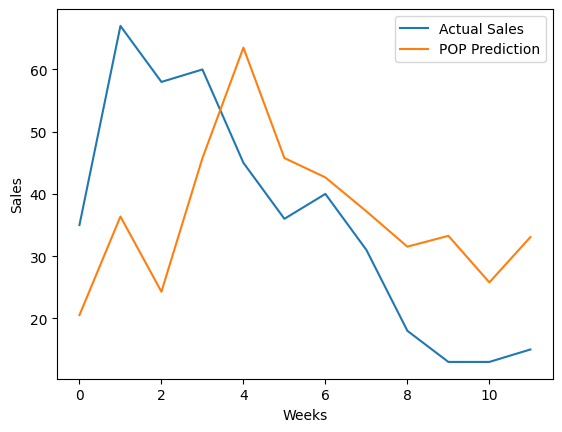

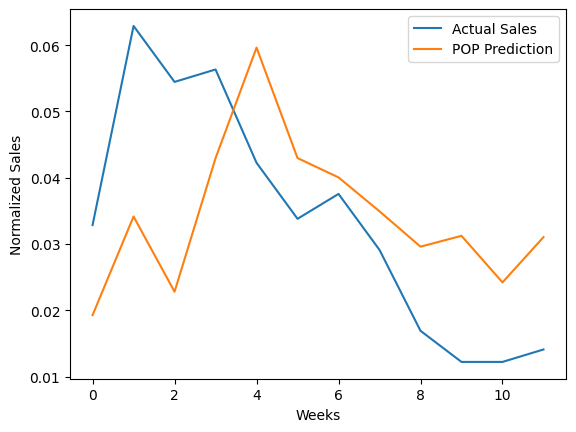

In [13]:
attns = np.stack(attns)
forecasts = np.array(forecasts)
gt = np.array(gt)

rescale_vals = np.load(args.data_folder + 'normalization_scale.npy')
rescaled_forecasts = forecasts * rescale_vals
rescaled_gt = gt * rescale_vals
print_error_metrics(gt, forecasts, rescaled_gt, rescaled_forecasts)


torch.save({'results': forecasts* rescale_vals, 'gts': gt* rescale_vals, 'codes': item_codes.tolist()}, Path('results/' + model_savename+'.pth'))

Category:  ['trapeze dress']
Color:  ['blue']
Texture:  ['milano stitch']


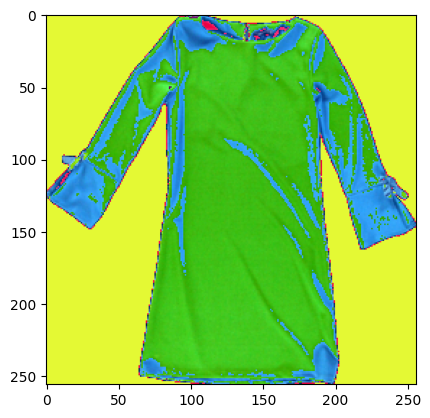

In [14]:
# define a transform to convert a tensor to PIL image
transform = T.ToPILImage()

# convert the tensor to PIL image using above transform
img = transform(images[0])

plt.imshow(img)

print("Category: ",get_key_from_dict(cat_dict, [attrs[0][0]]))
print("Color: ",get_key_from_dict(col_dict, attrs[0][2]))
print("Texture: ",get_key_from_dict(fab_dict, [attrs[0][1]]))


In [15]:
def forecast_item(item_sales, category, color, textures, temporal_features, gtrends, images):
    #Get prediction    
    

SyntaxError: incomplete input (351030025.py, line 3)

In [ ]:
pop_signal